In [1]:
'''
Dependencies
'''
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from importlib import reload
from numpy import linalg as LA
from scipy.stats import ks_2samp
from pyaldata import *
from rutils import *
from distance_methods import *
import distance_methods
reload(distance_methods)
import re

'''
Plotting aesthetics
'''
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)
cmap = sns.light_palette(color='#183D51', as_cmap=True)
div_cmap = sns.diverging_palette(250, 150, as_cmap=True)
cs = ['#732514', '#FEB312', '#233A6A', '#545340', '#4E81AF', '#183D51']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cs)
np.set_printoptions(suppress=True, precision=3)

'''
Magic commands
'''
%config InlineBackend.figure_format = 'retina'

In [19]:
#?plt.plot

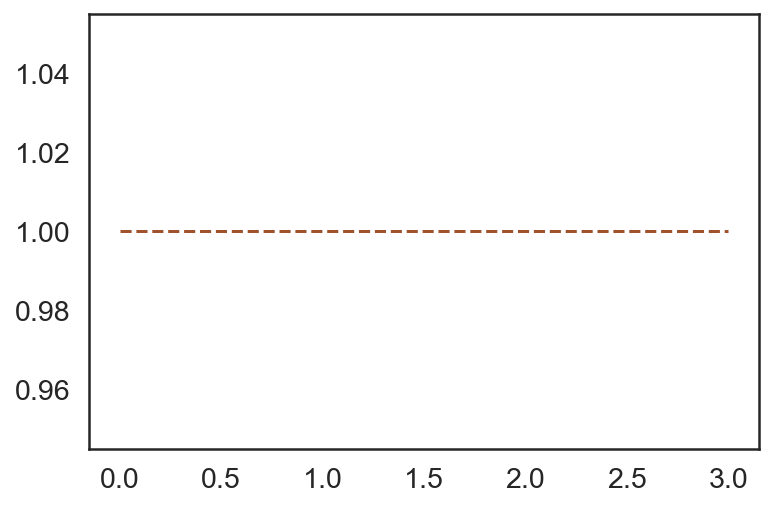

In [22]:
plt.plot(np.ones(4), c='sienna', ls='--')

## Select session and run data analyses

___________
Analyzing session 2016-09-09 with Chewie
___________


/Users/Daphne/Desktop/Spatial/PyalData/pyaldata/tools.py:1061: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/Users/Daphne/Desktop/Spatial/PyalData/pyaldata/tools.py:1061: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


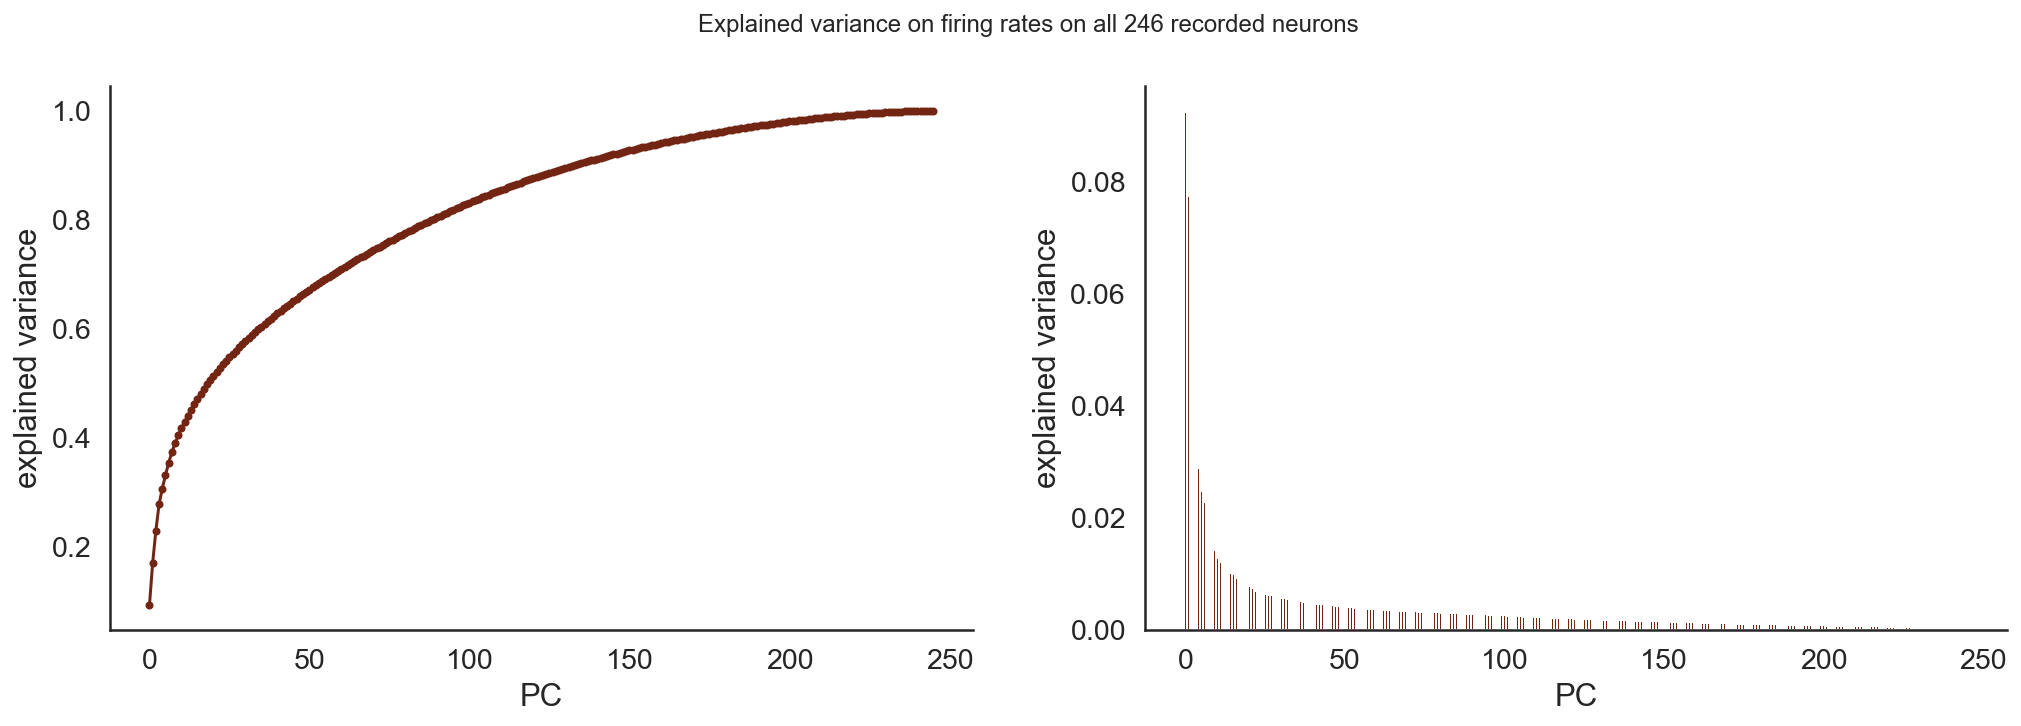

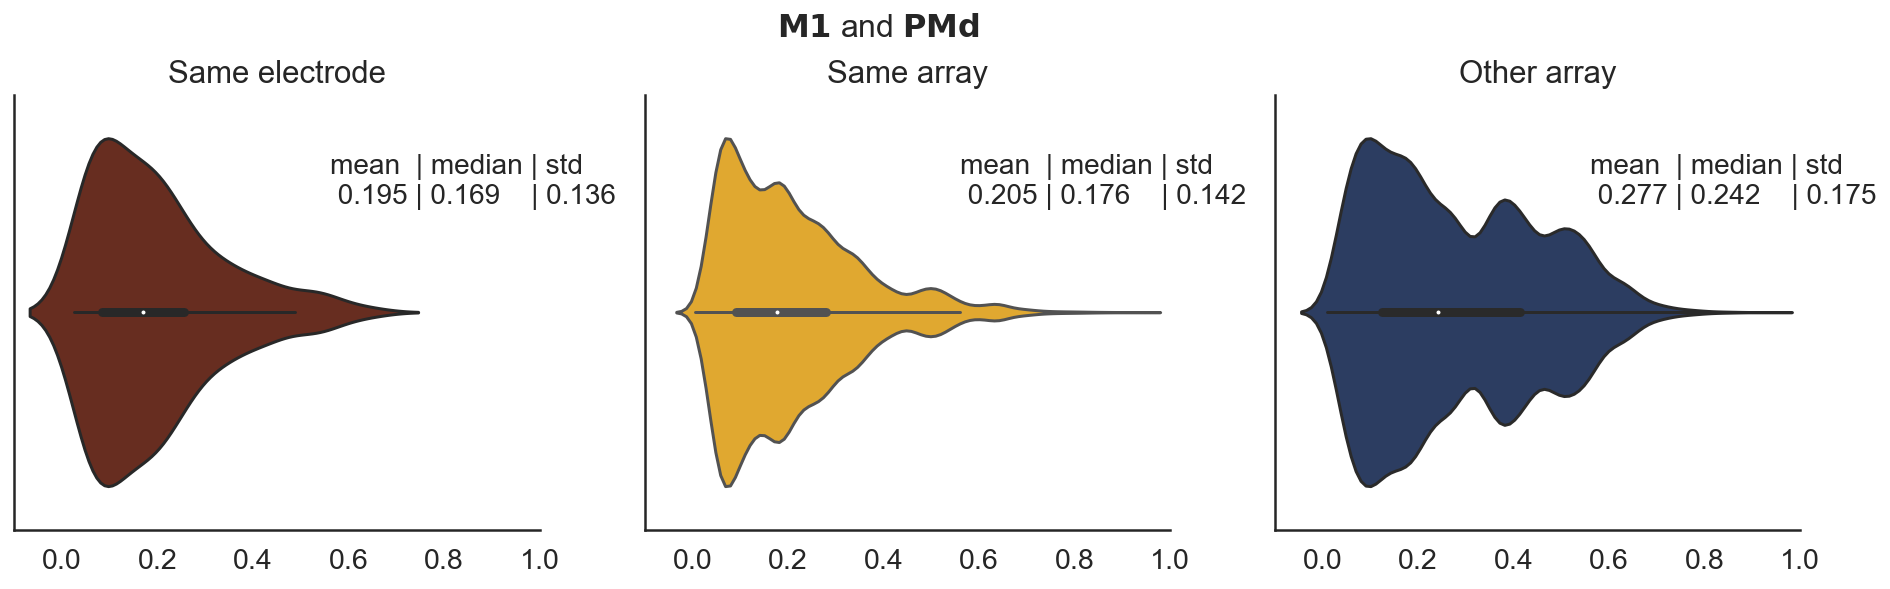

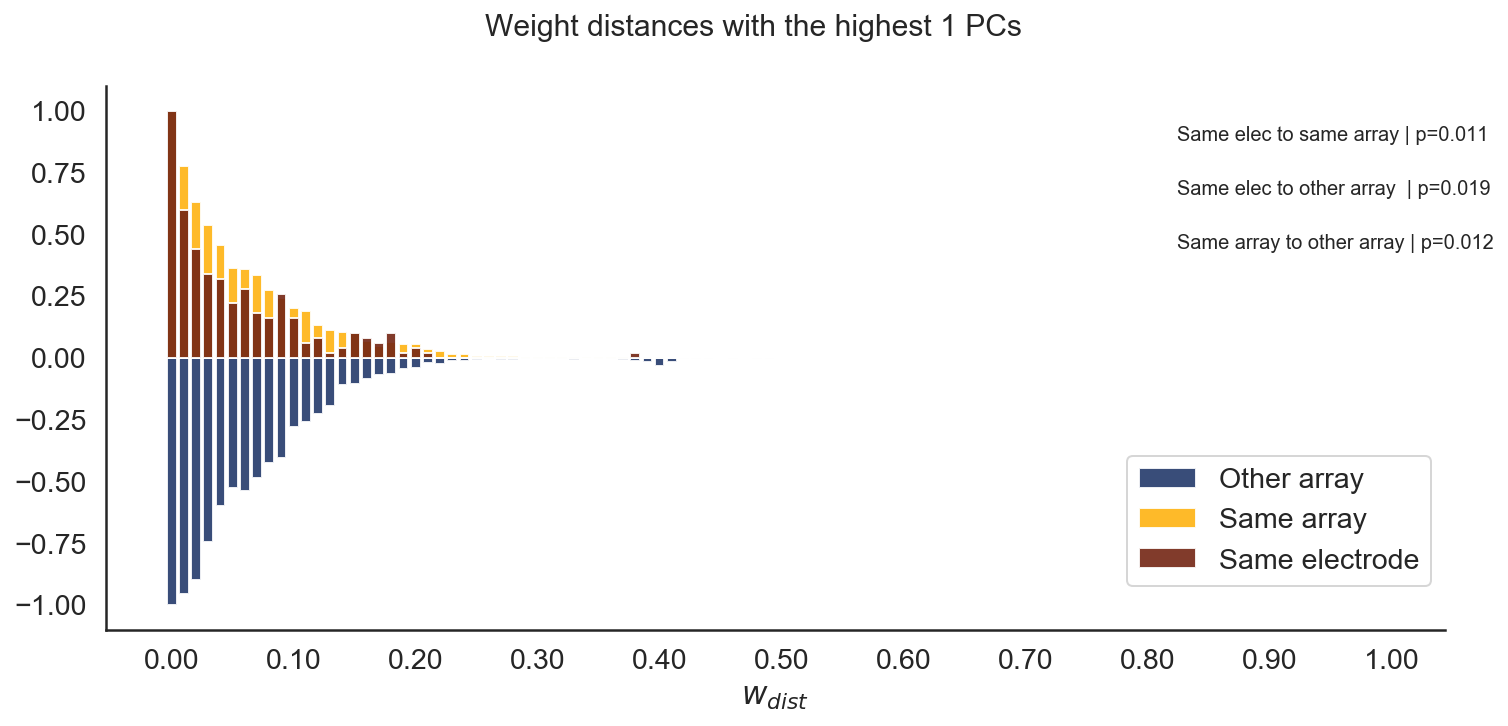

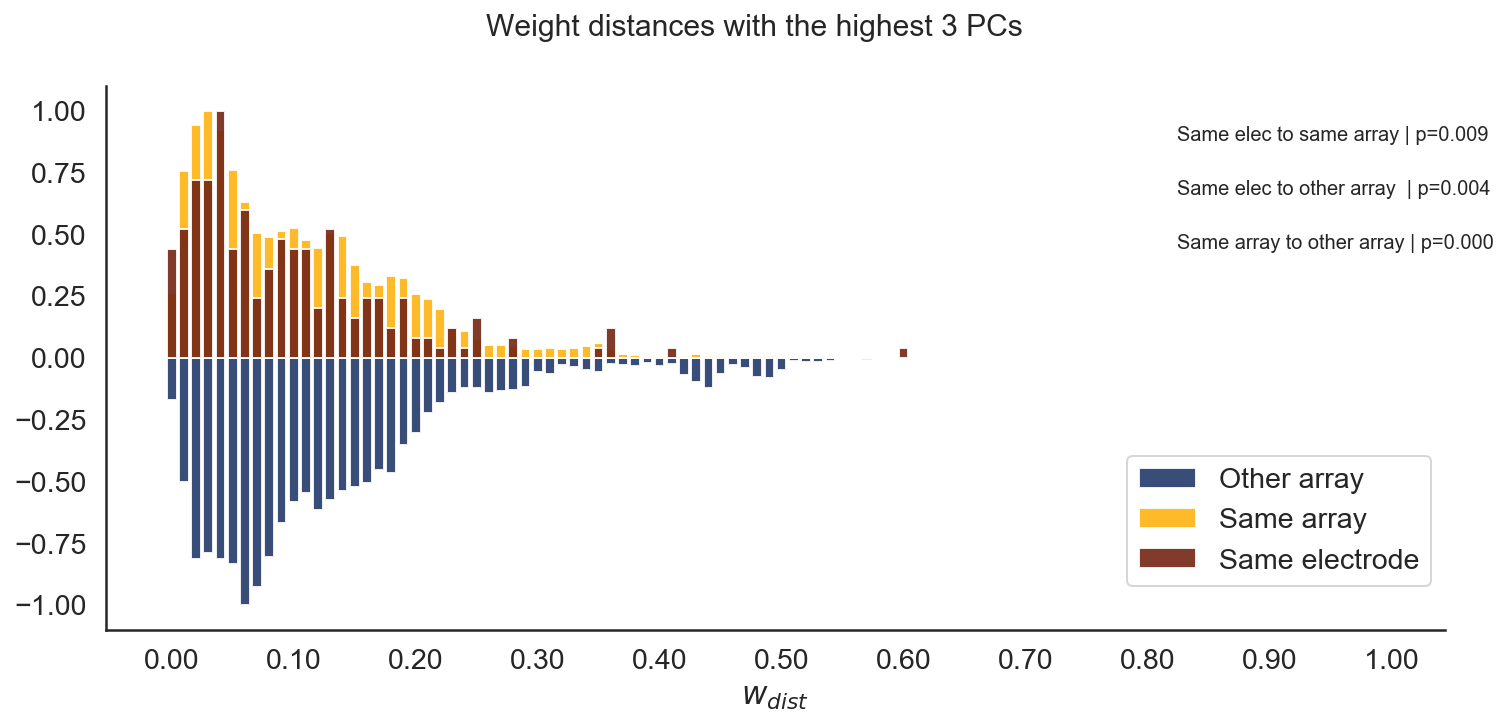

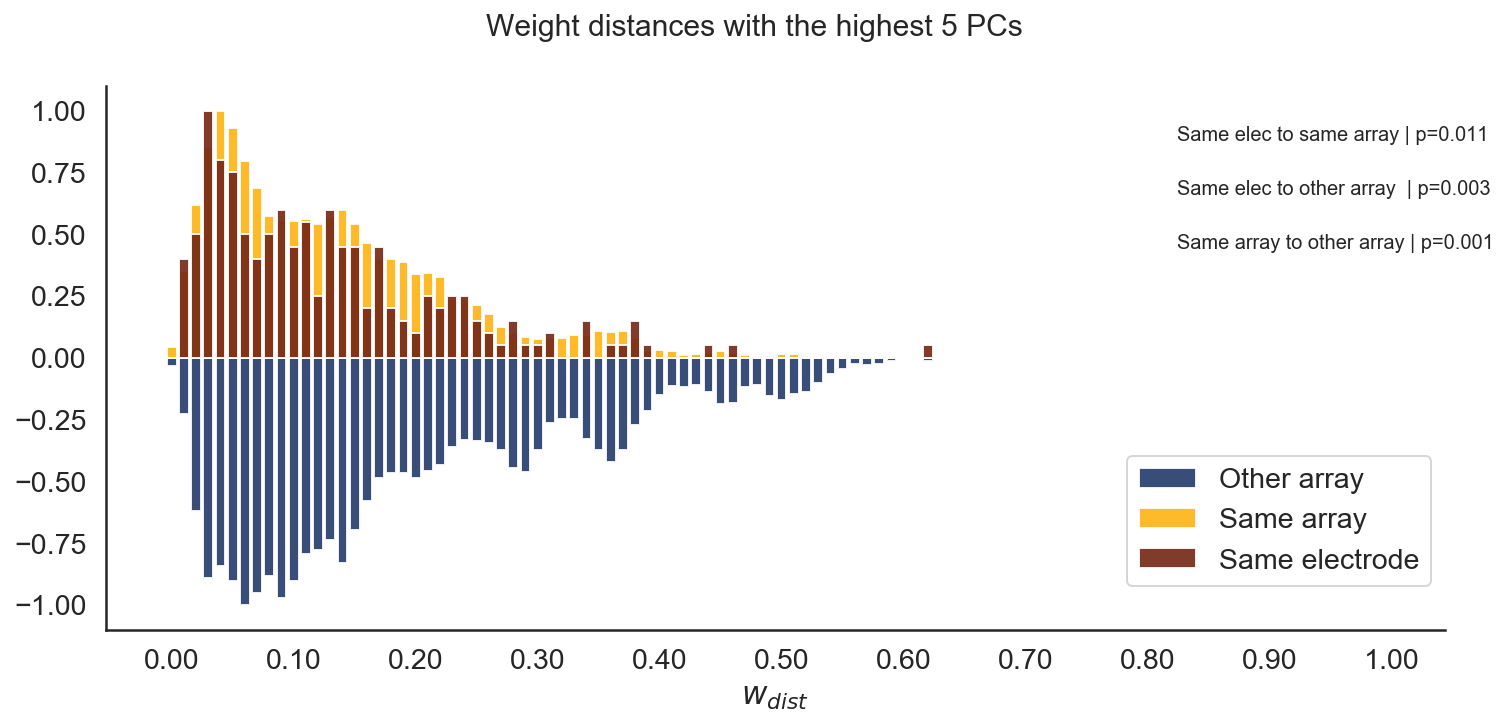

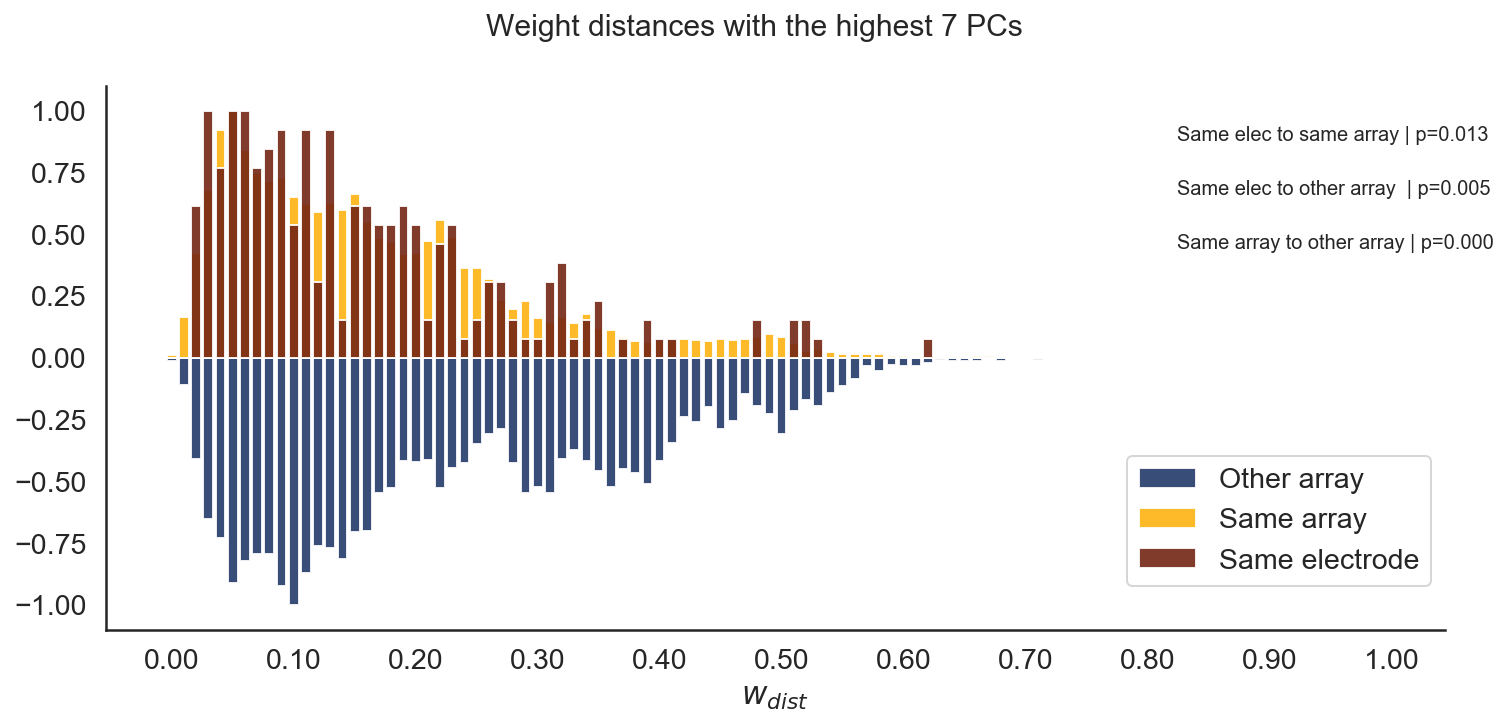

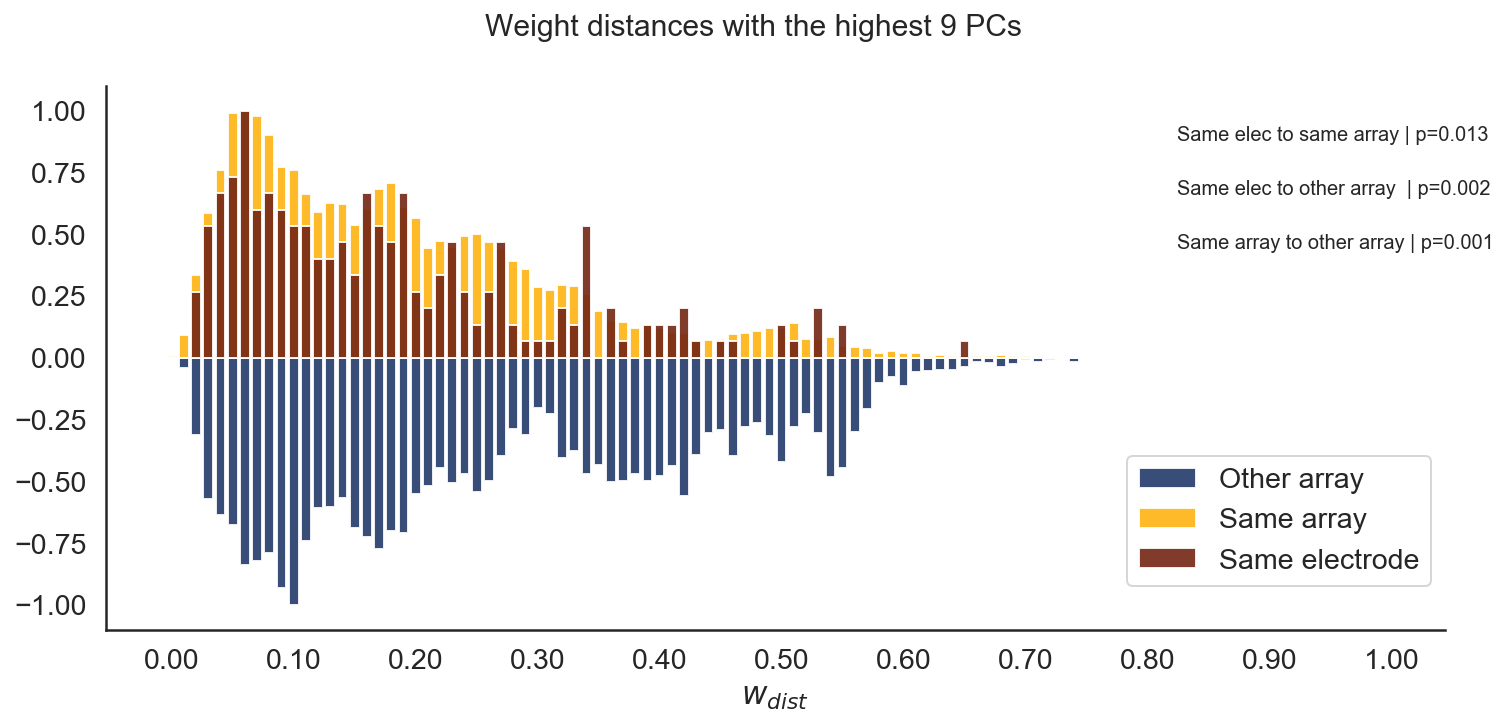

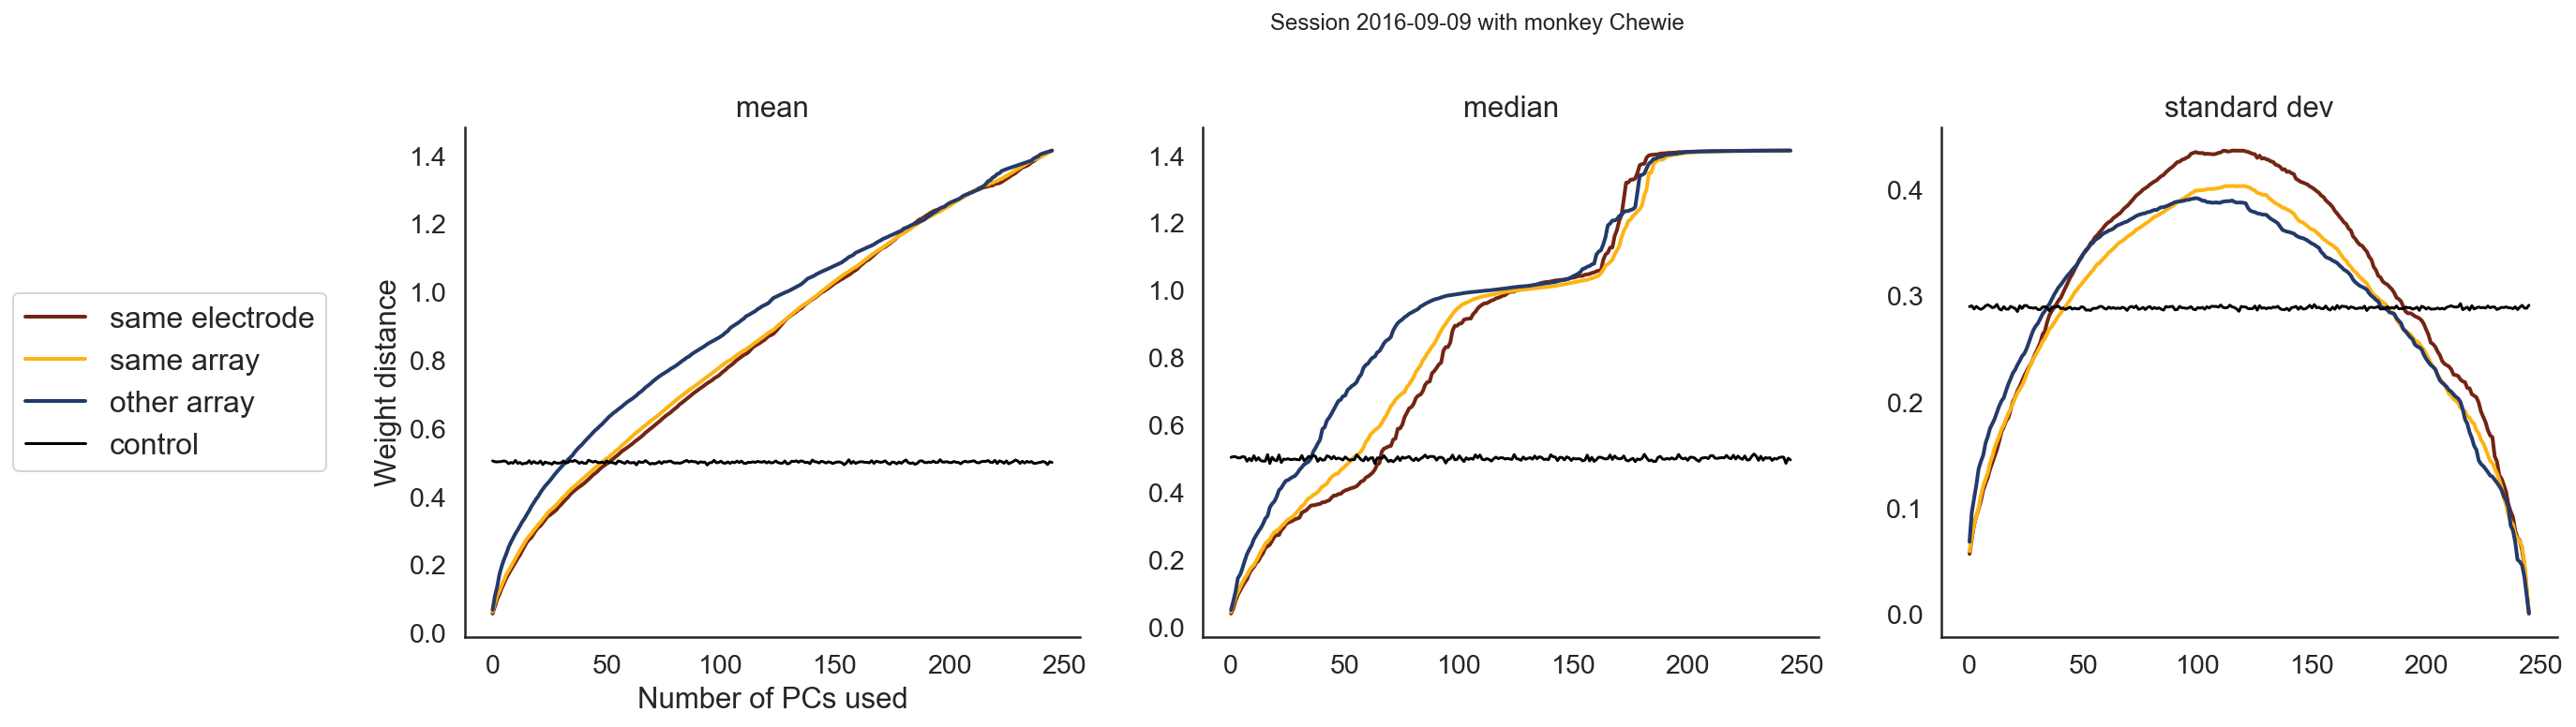

______________
Analysis Done
______________


In [4]:
session = 'Chewie_CO_VR_2016-09-09.mat'  # File matt used to generate initial figures in matlab

run_analyses(session)

___________
Analyzing session 2016-10-07 with Chewie
___________


/Users/Daphne/Desktop/Spatial/PyalData/pyaldata/tools.py:1061: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/Users/Daphne/Desktop/Spatial/PyalData/pyaldata/tools.py:1061: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


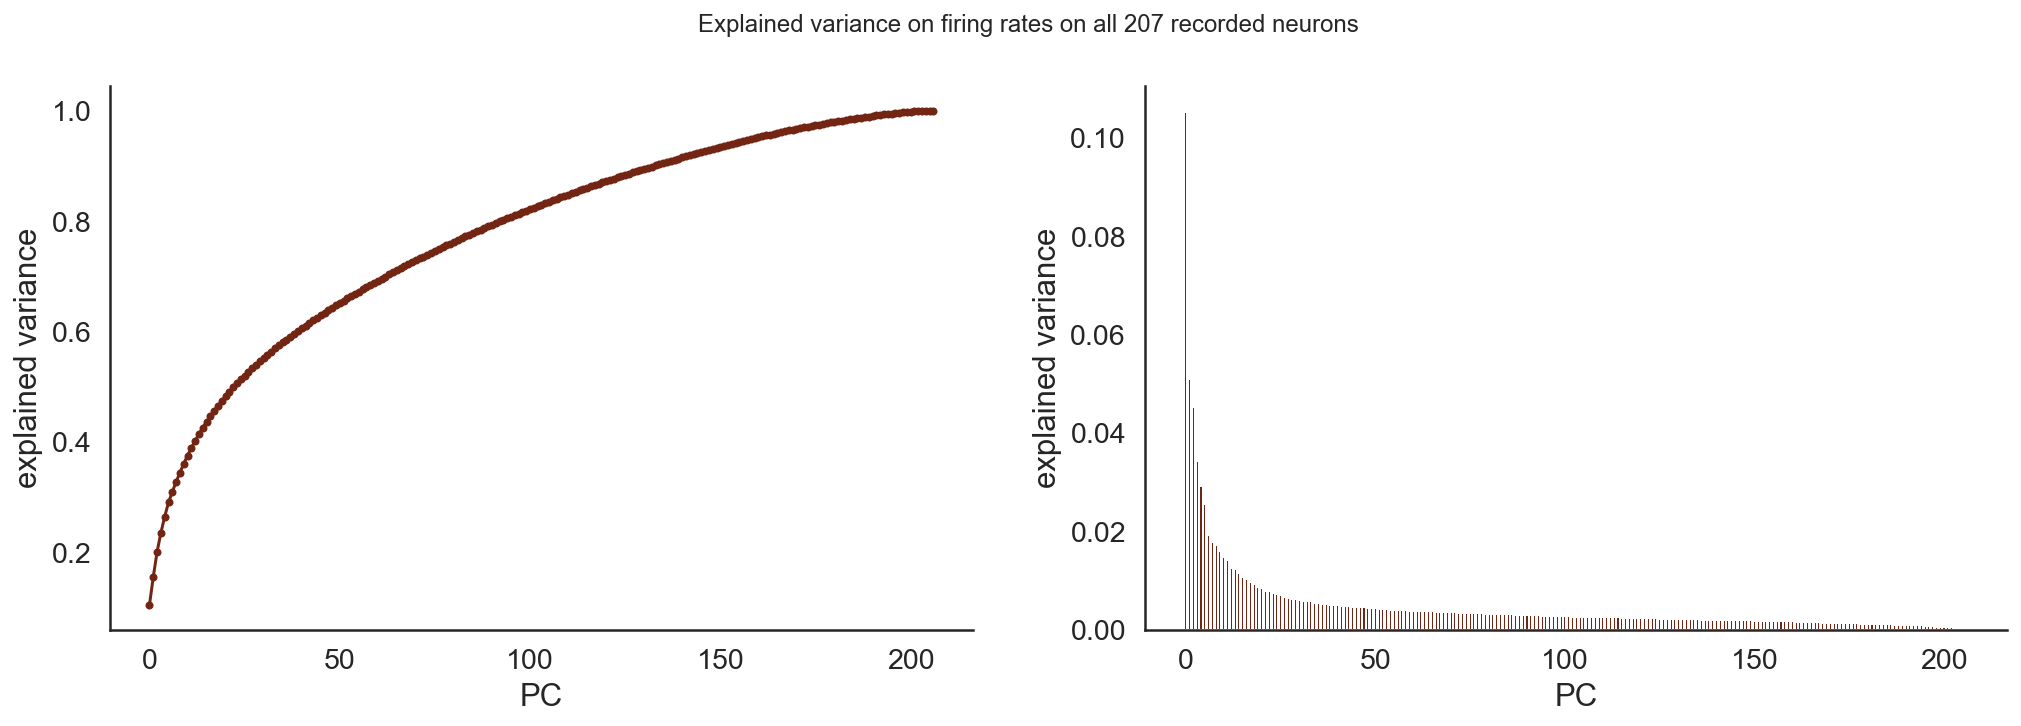

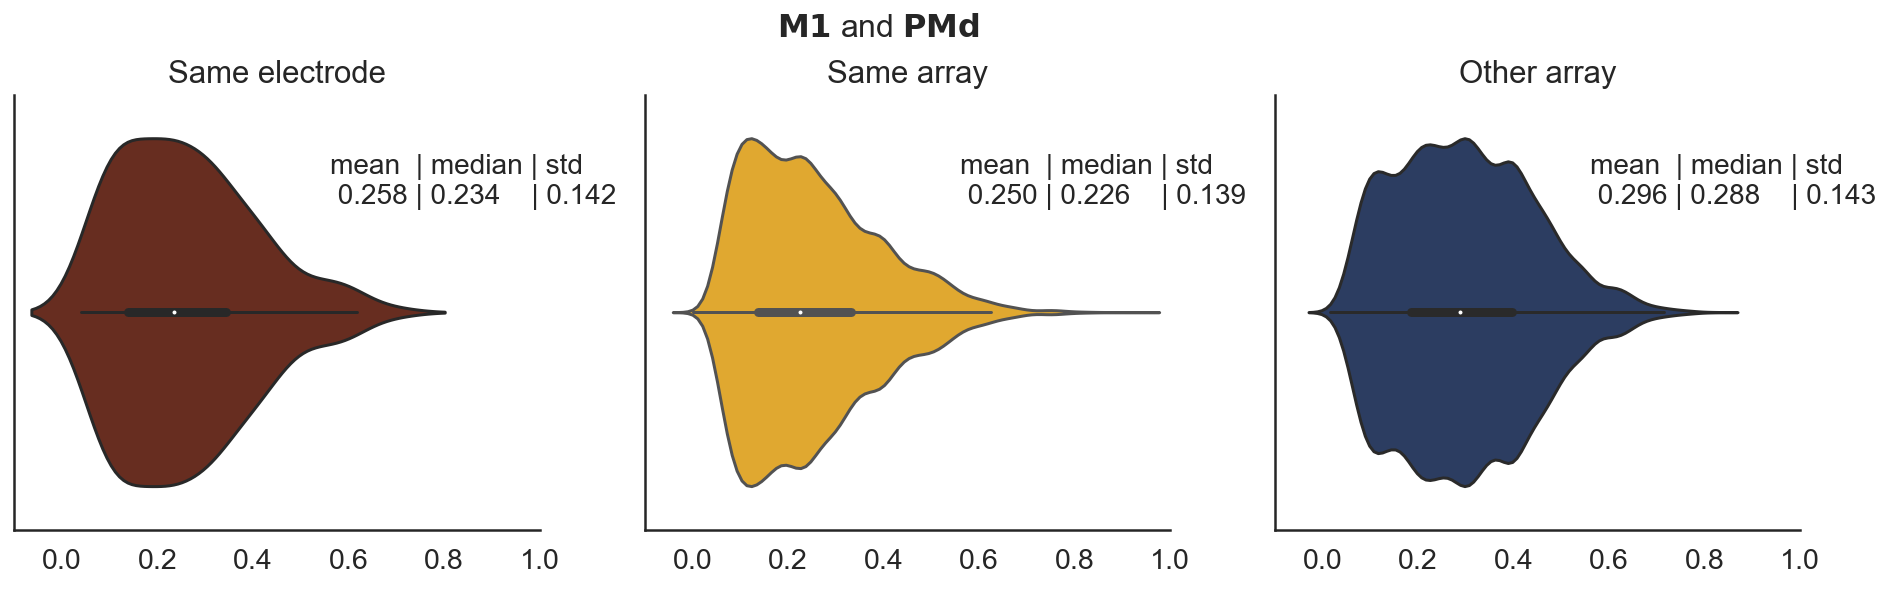

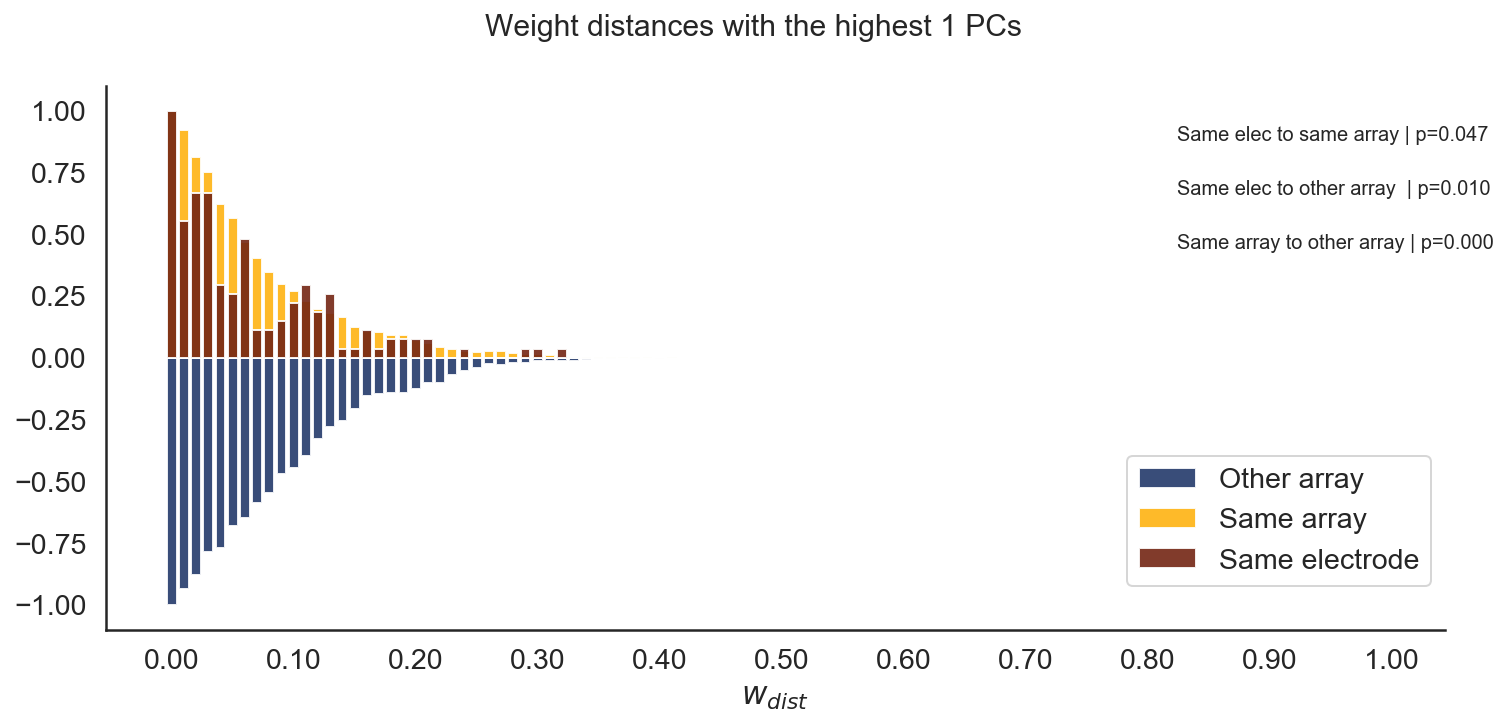

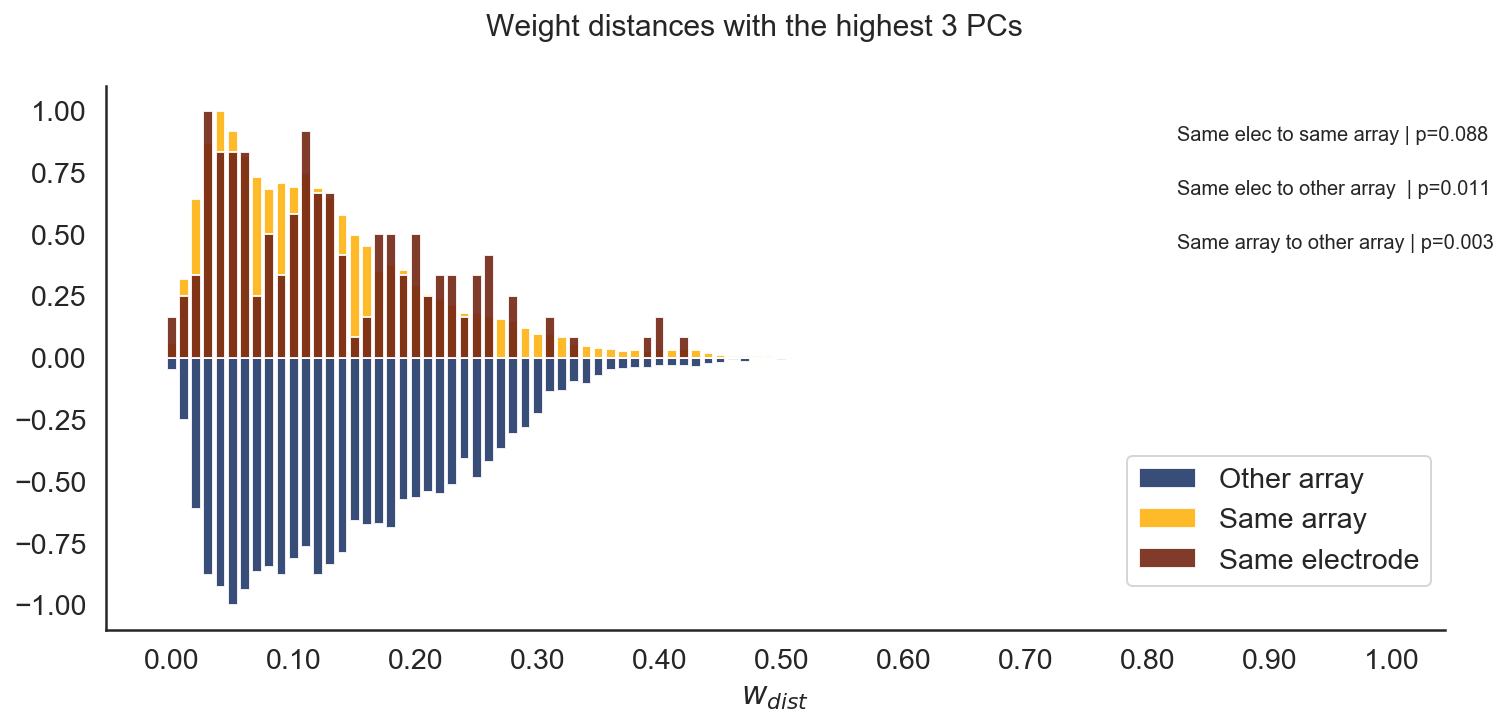

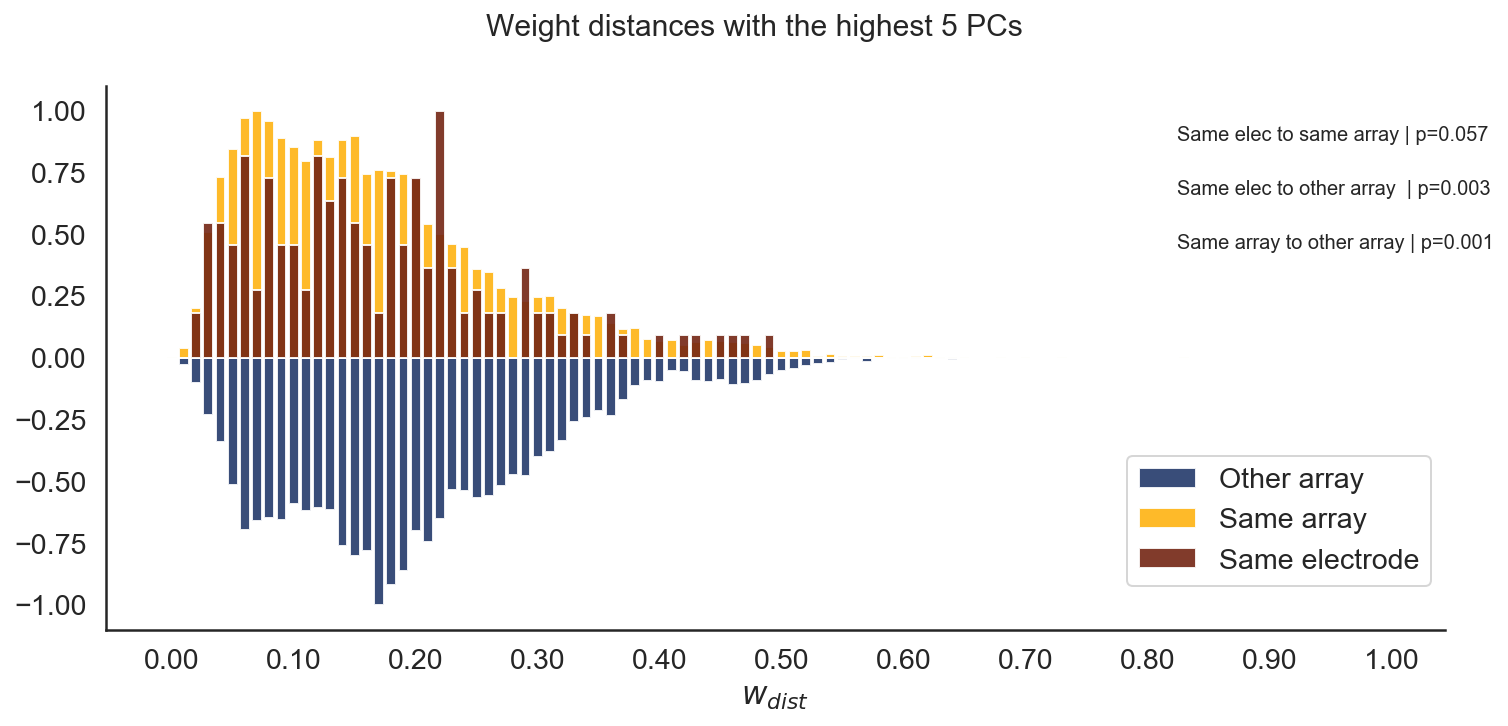

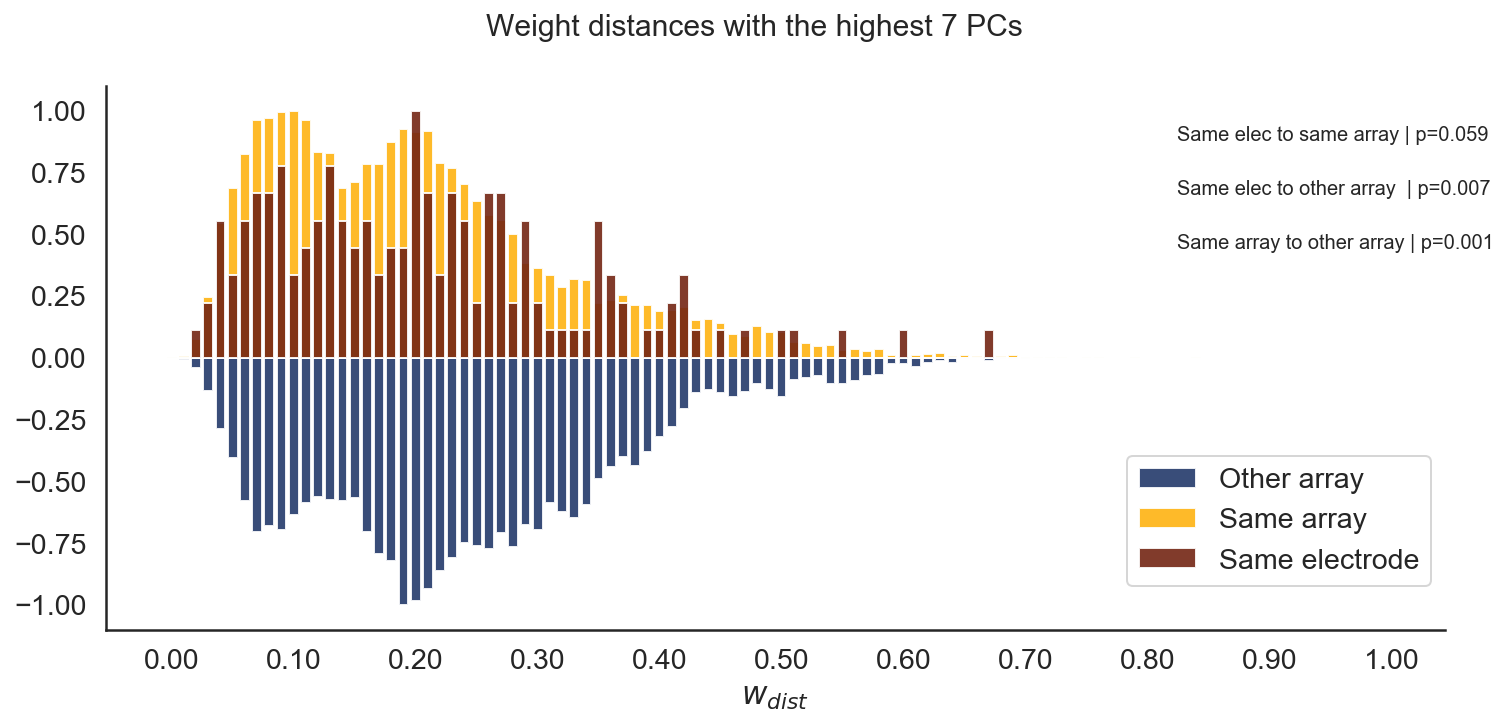

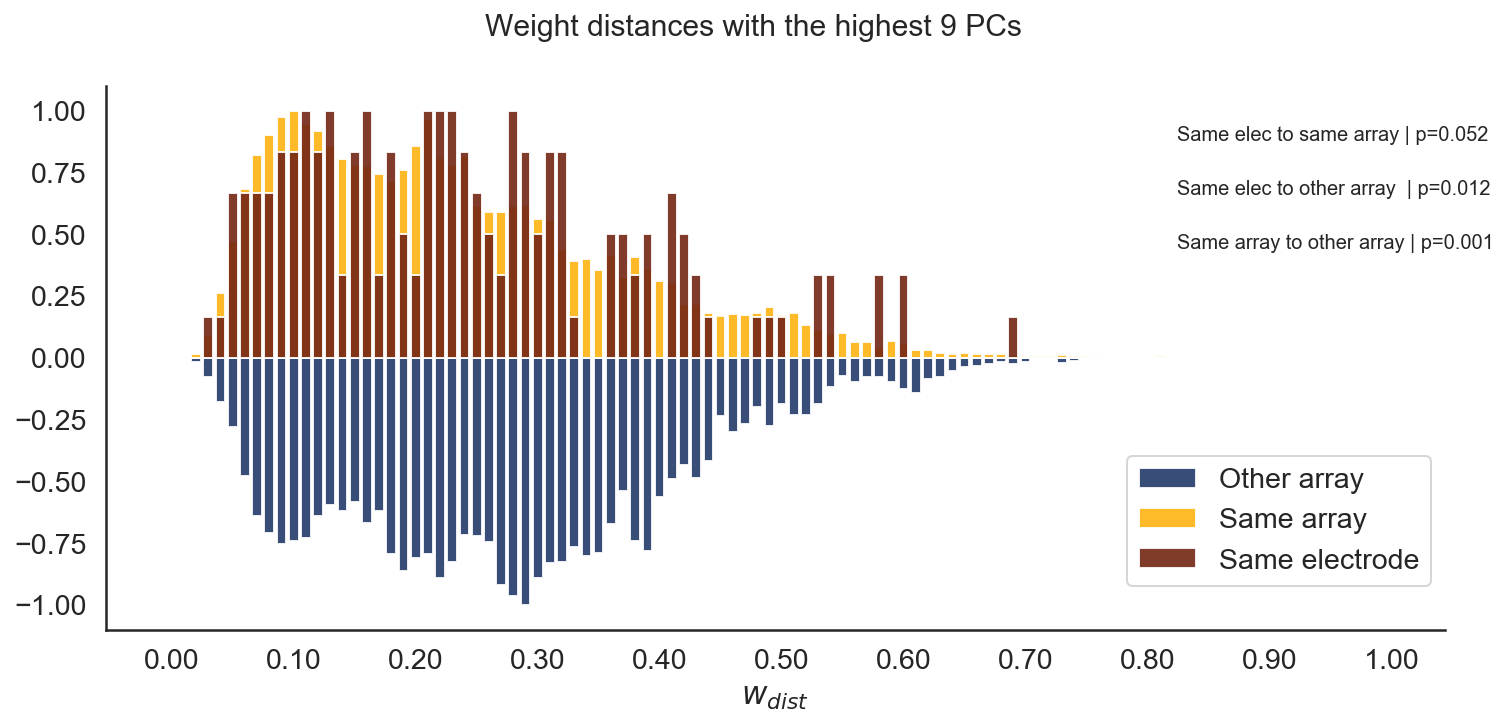

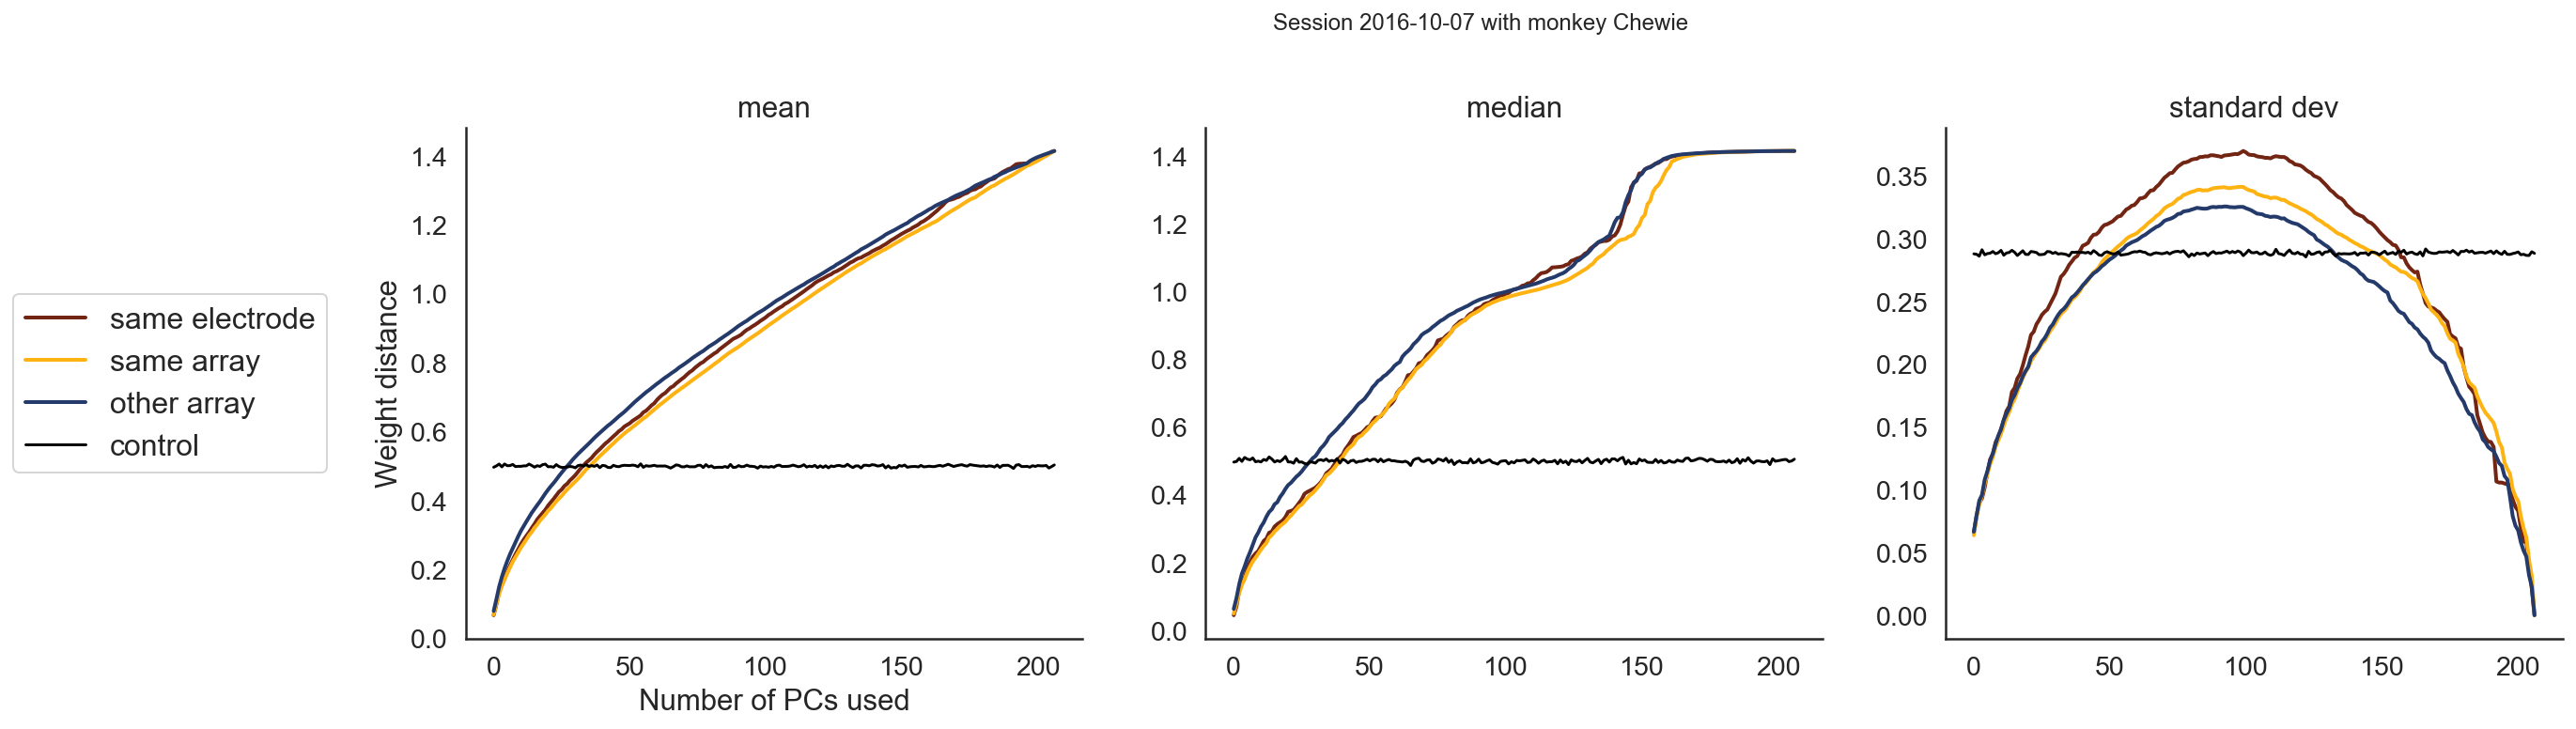

______________
Analysis Done
______________


In [5]:
session = 'Chewie_CO_FF_2016-10-07.mat' # Other one matt used

run_analyses(session)

___________
Analyzing session 2016-09-21 with Chewie
___________


/Users/Daphne/Desktop/Spatial/PyalData/pyaldata/tools.py:1061: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/Users/Daphne/Desktop/Spatial/PyalData/pyaldata/tools.py:1061: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


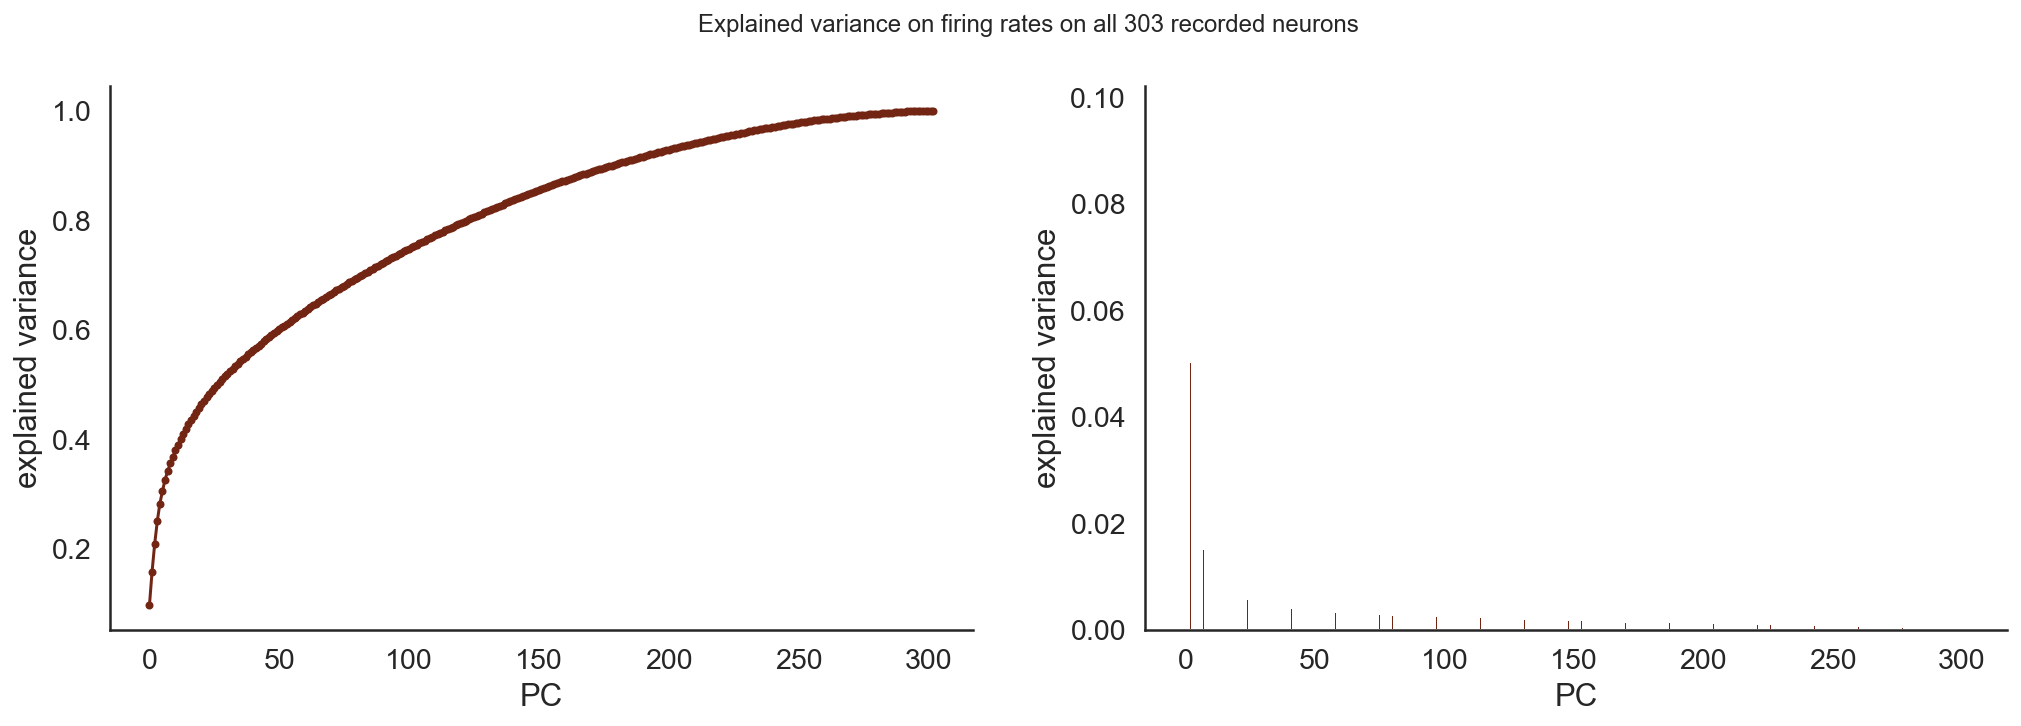

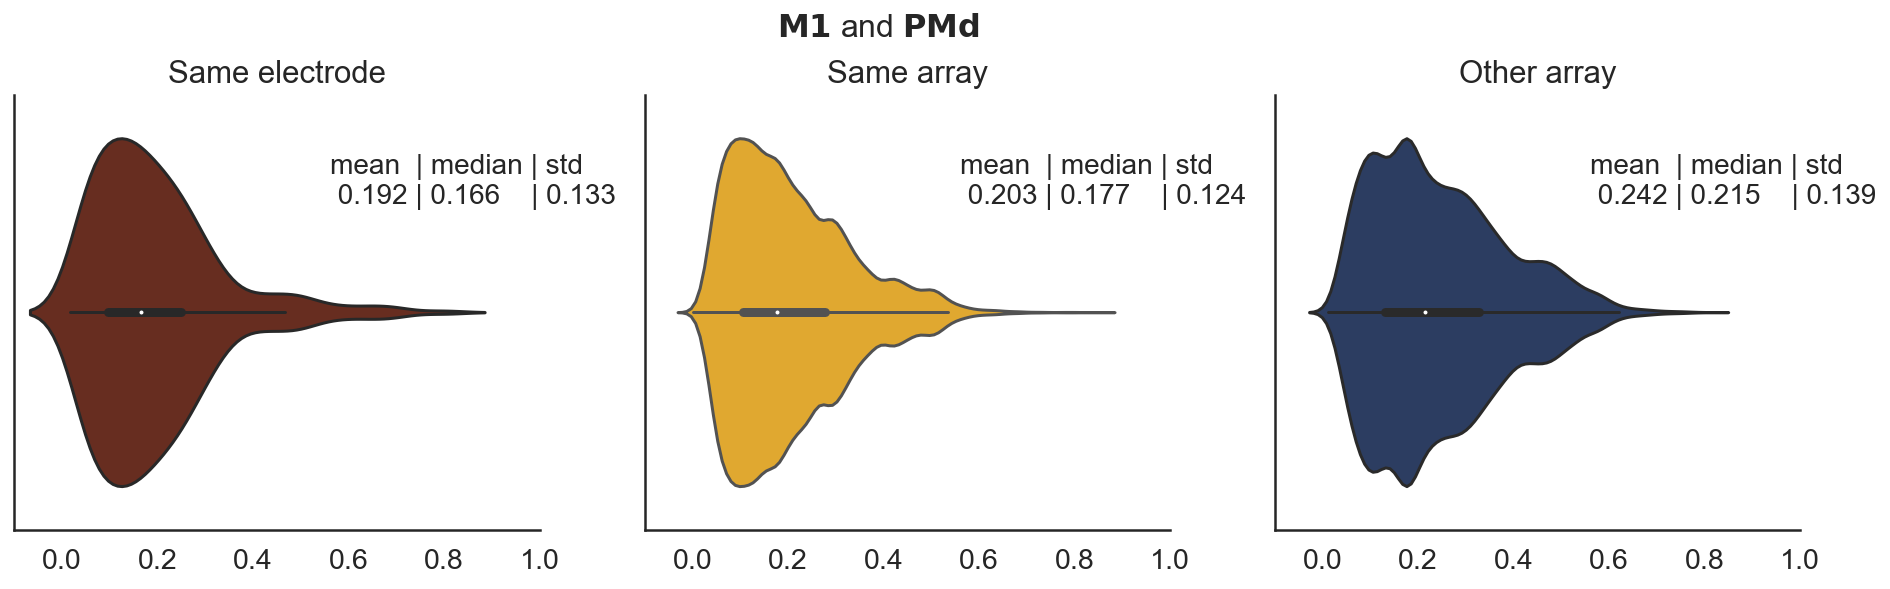

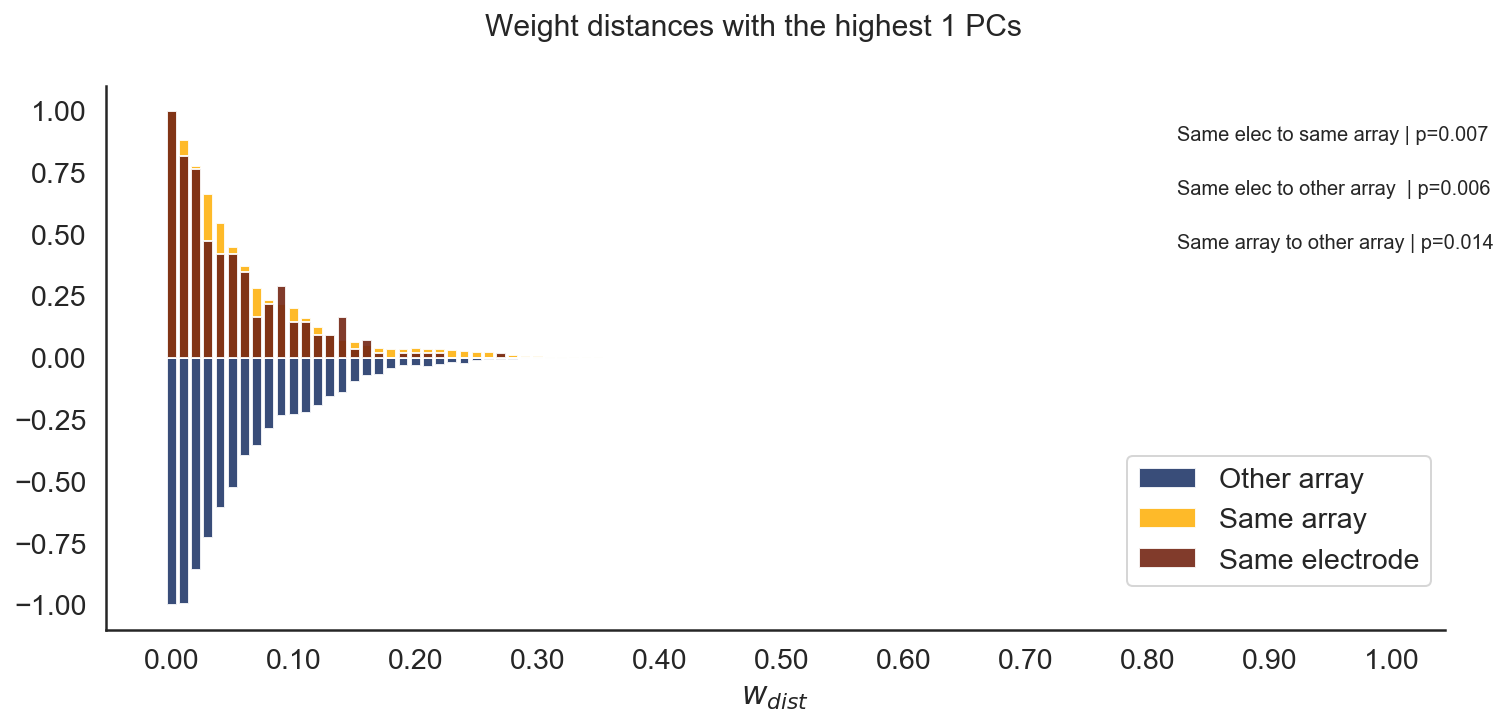

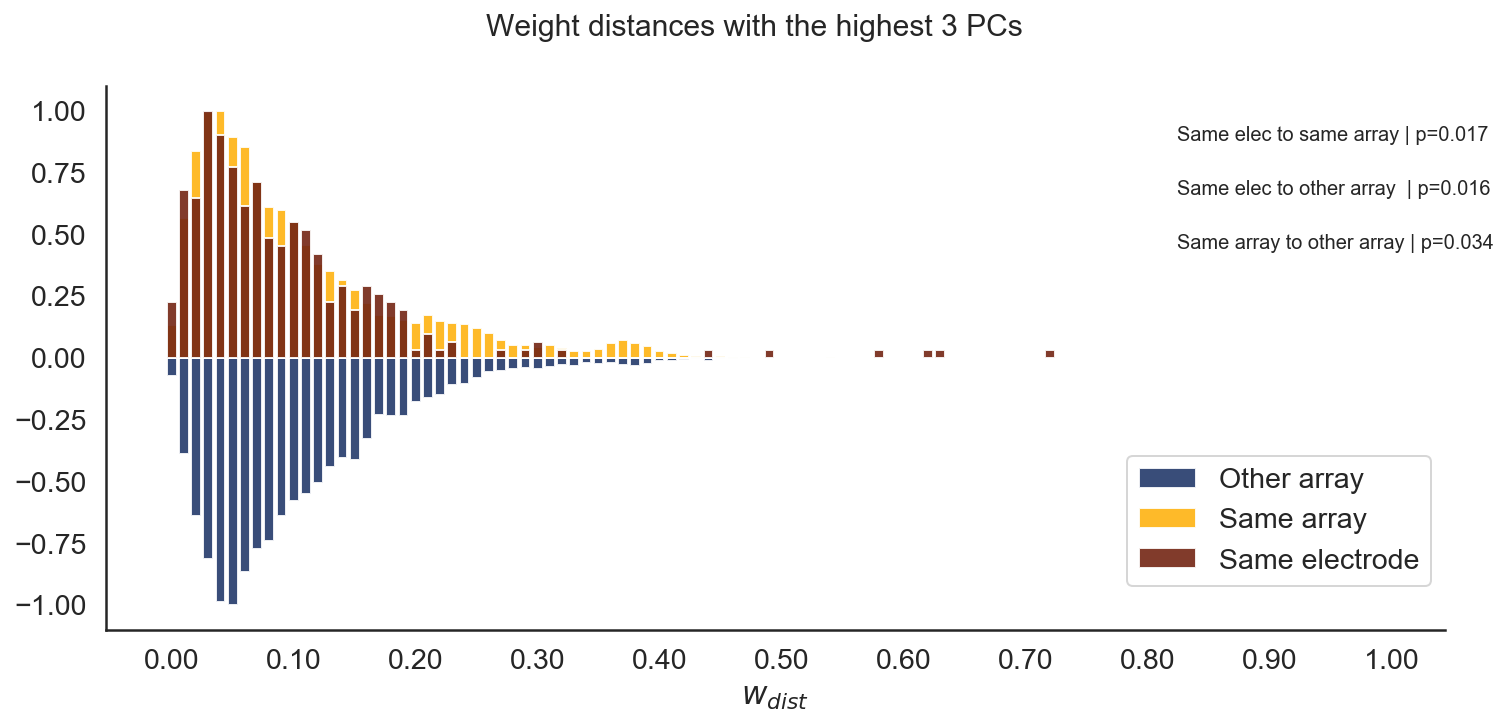

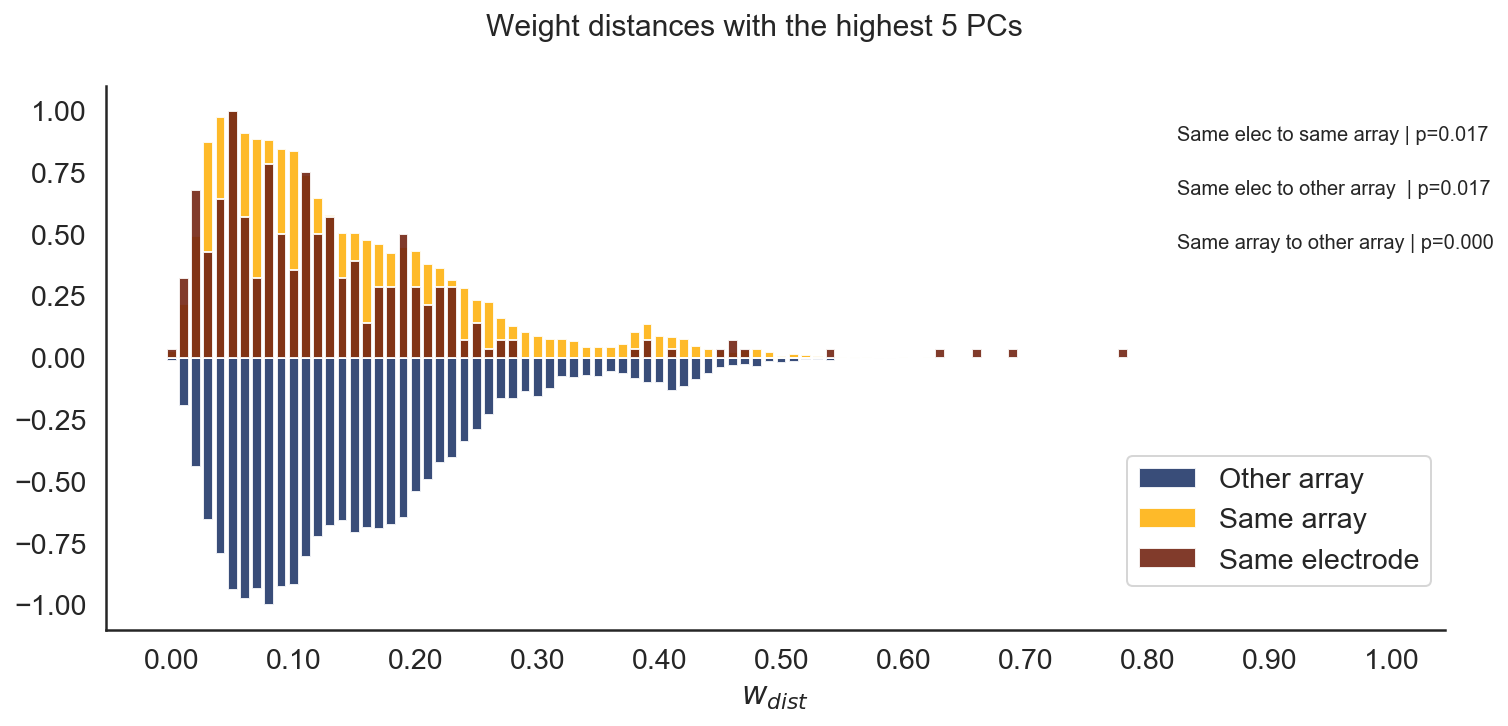

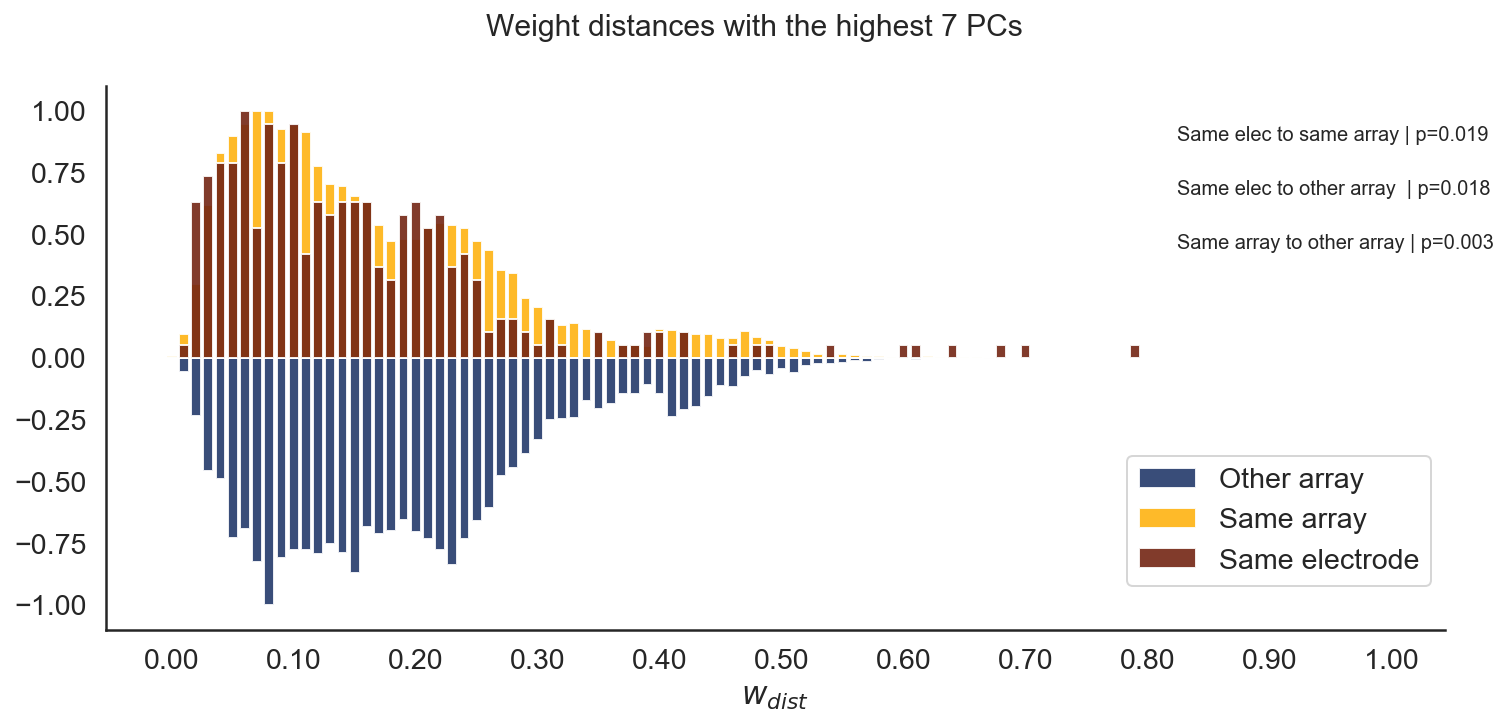

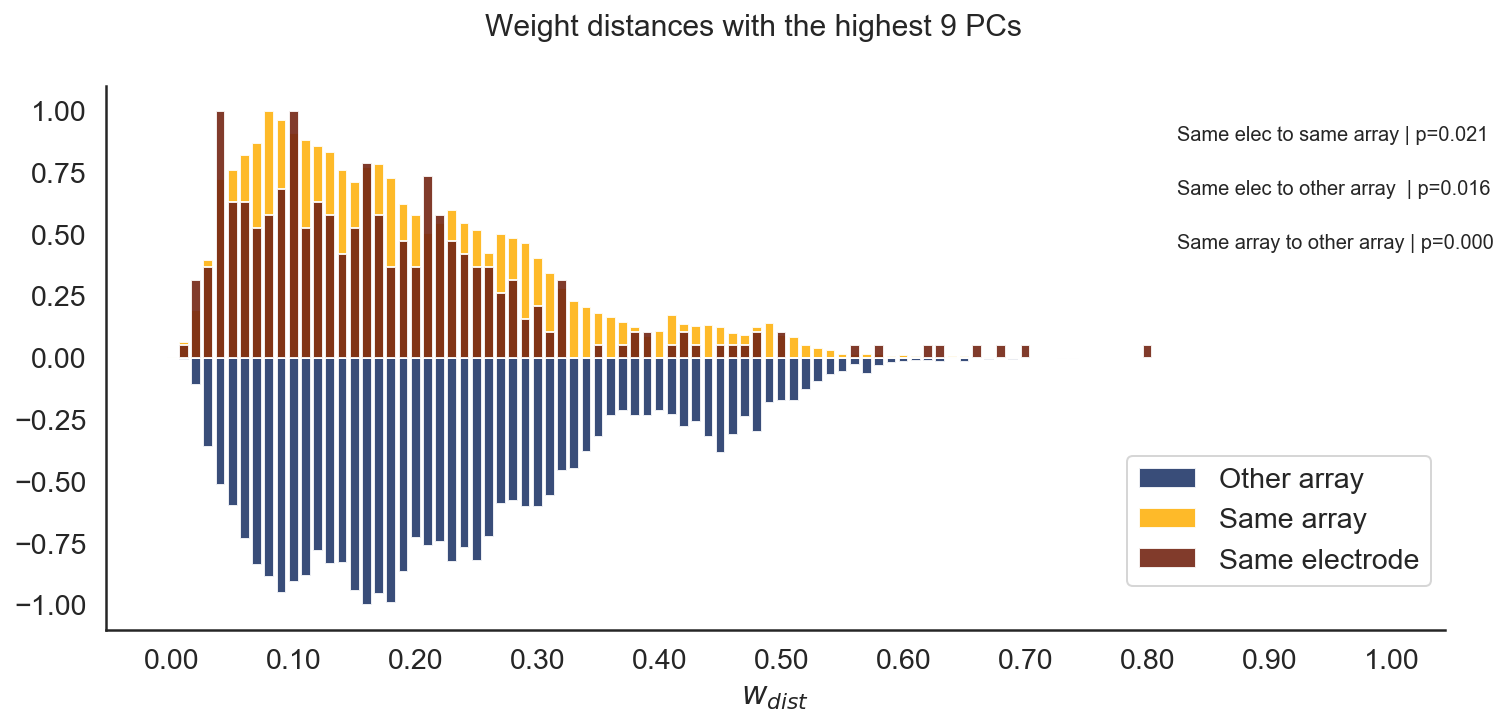

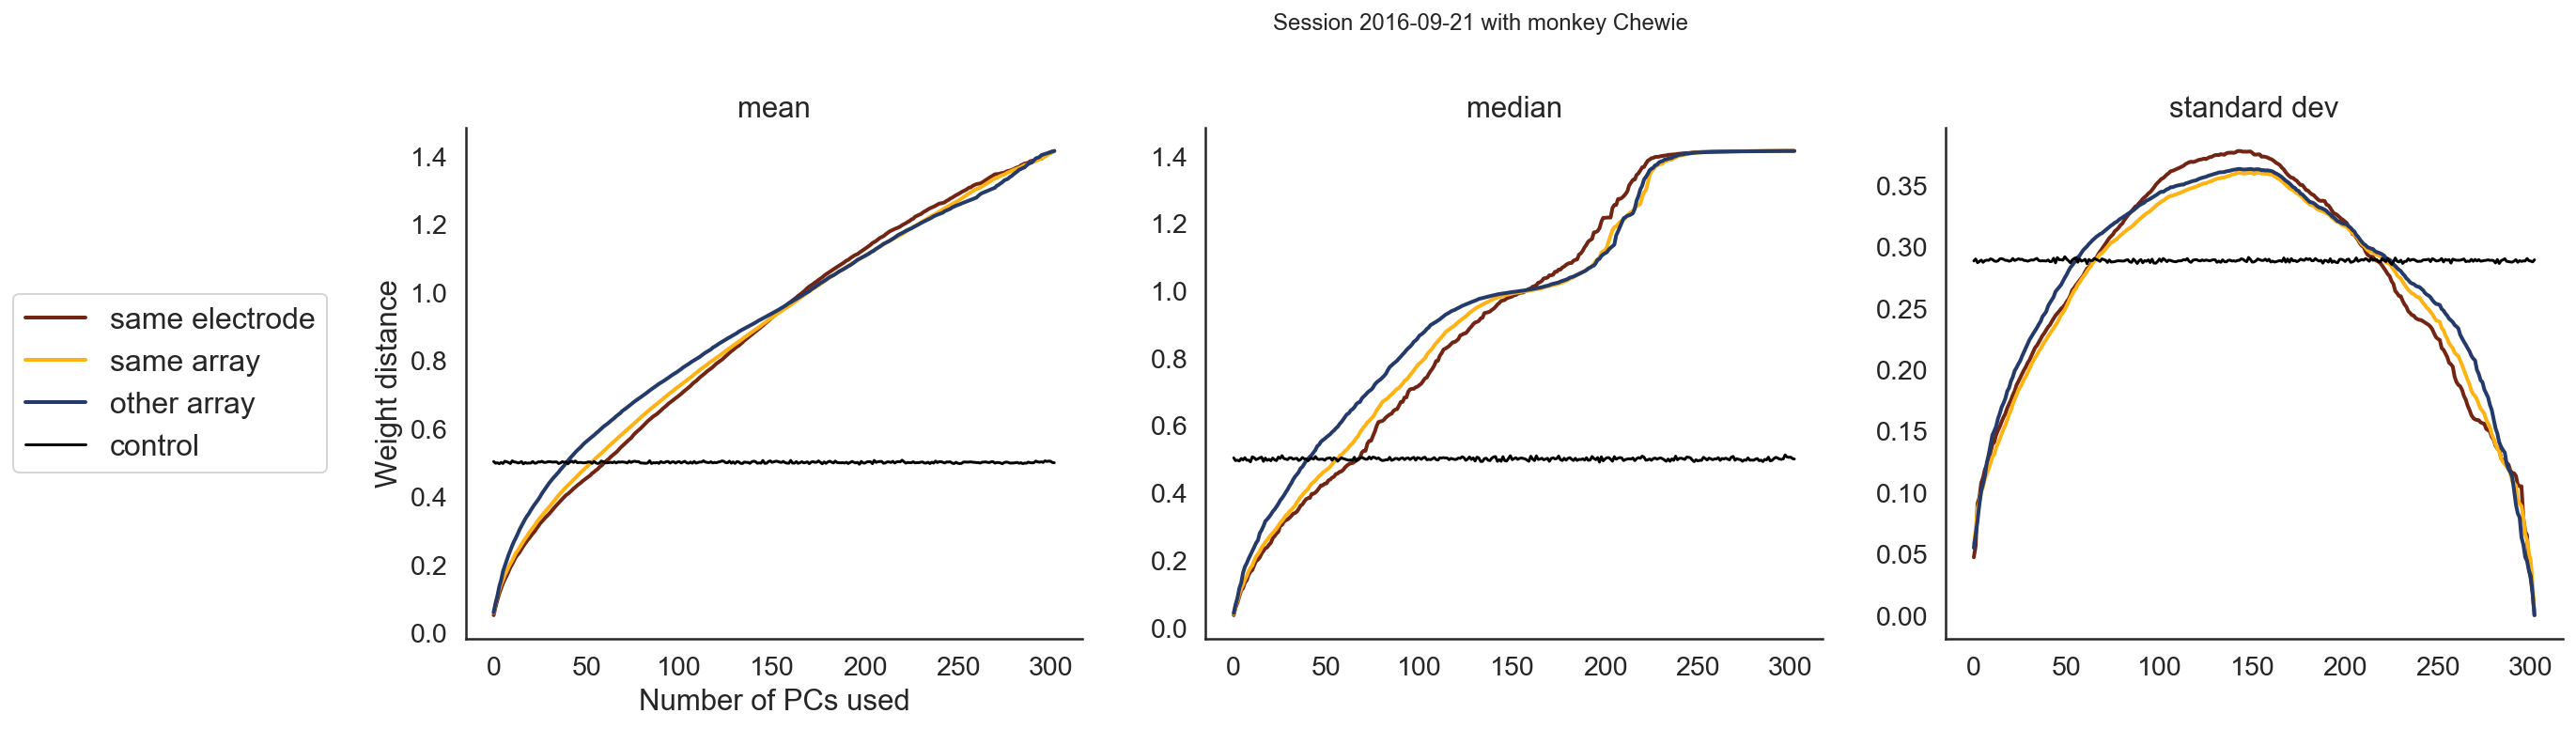

______________
Analysis Done
______________


In [6]:
session = 'Chewie_CO_FF_2016-09-21.mat' # My initial file

run_analyses(session)

___________
Analyzing session 2016-10-06 with Chewie
___________


/Users/Daphne/Desktop/Spatial/PyalData/pyaldata/tools.py:1061: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/Users/Daphne/Desktop/Spatial/PyalData/pyaldata/tools.py:1061: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


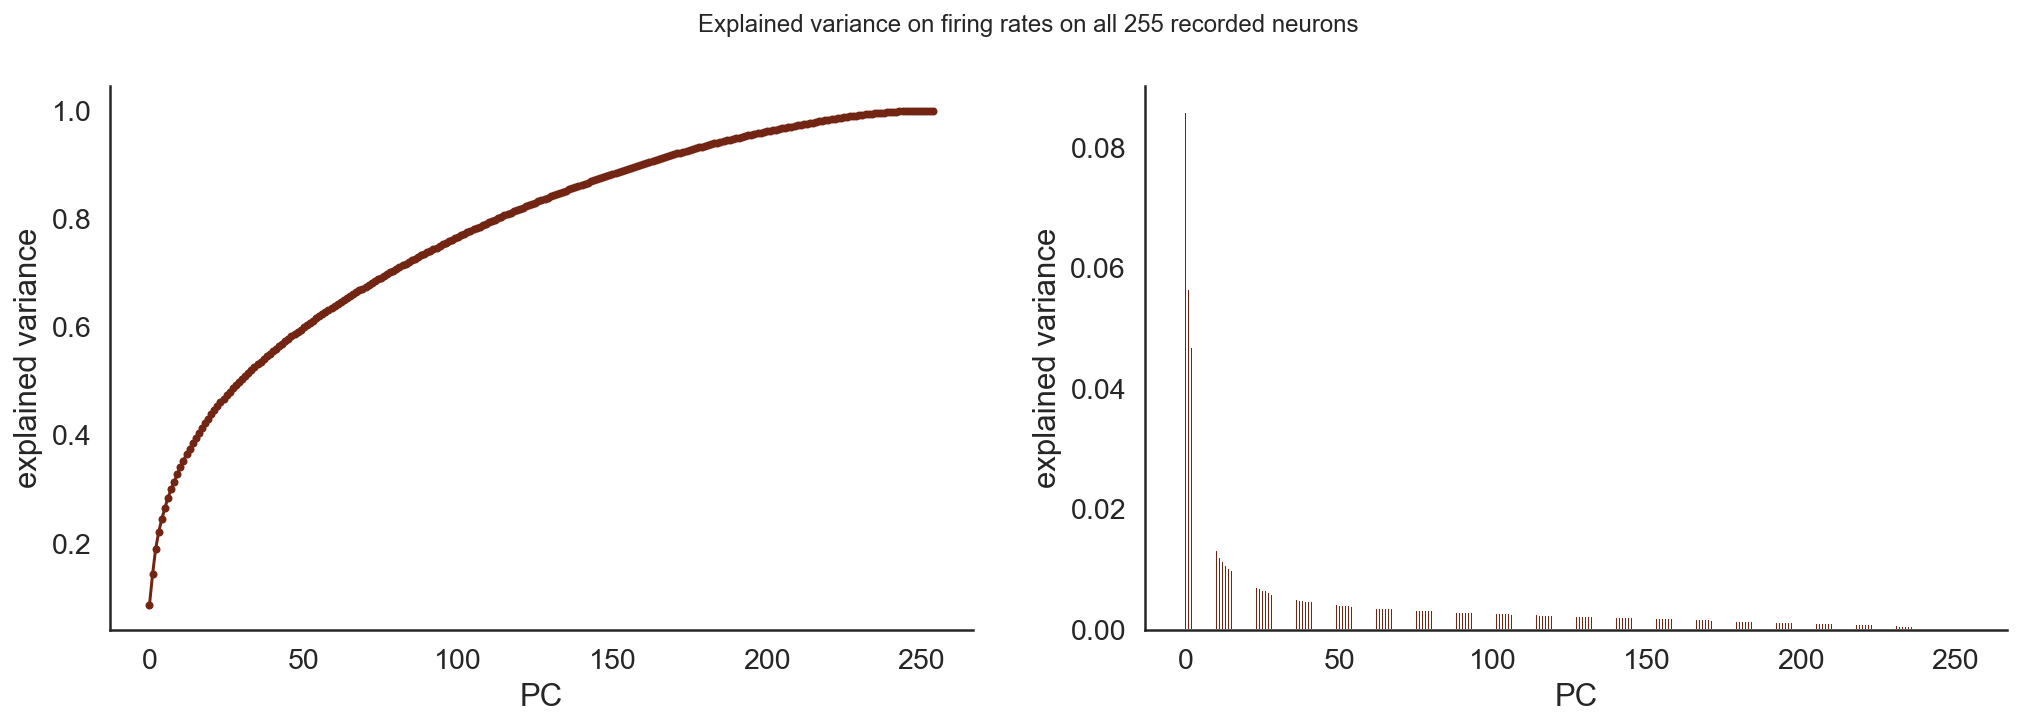

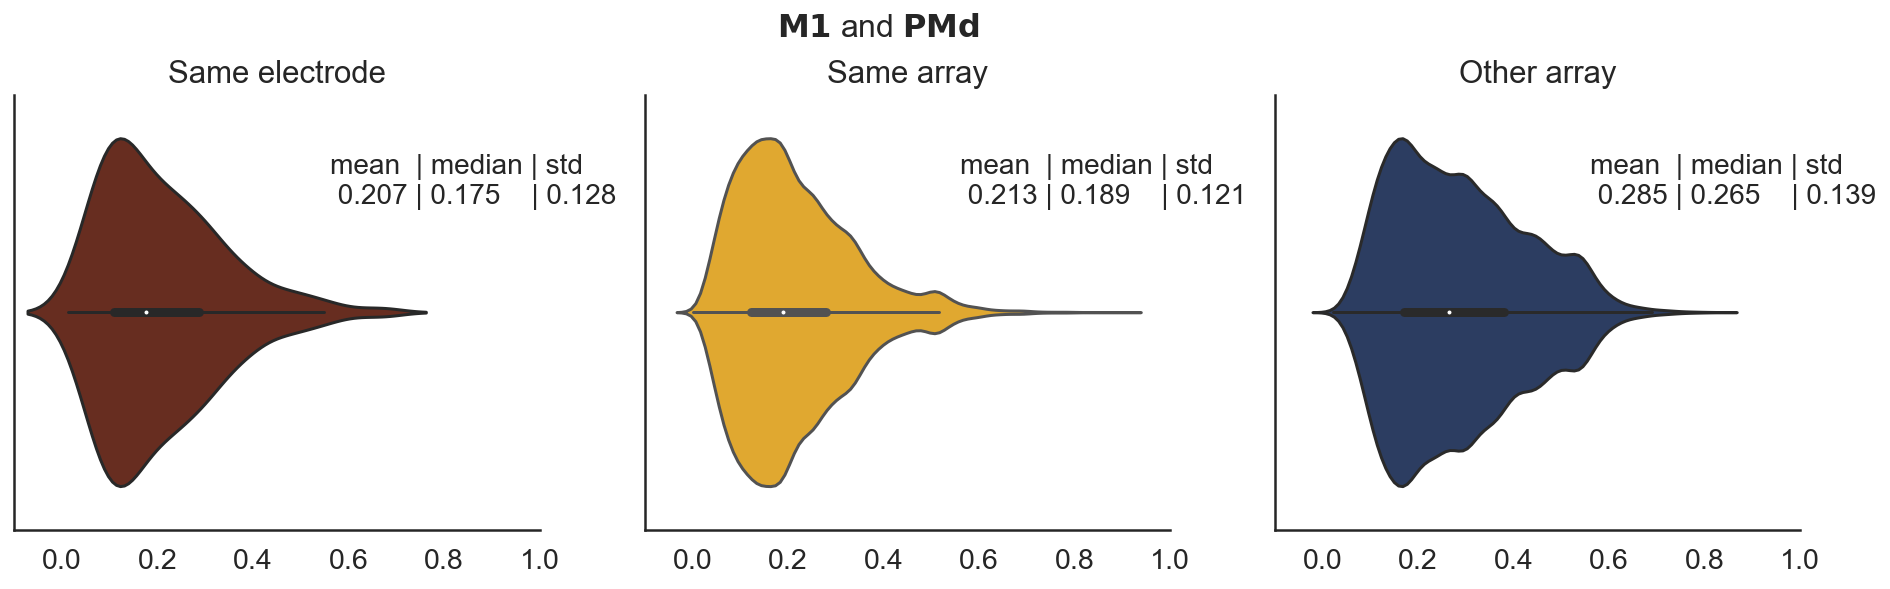

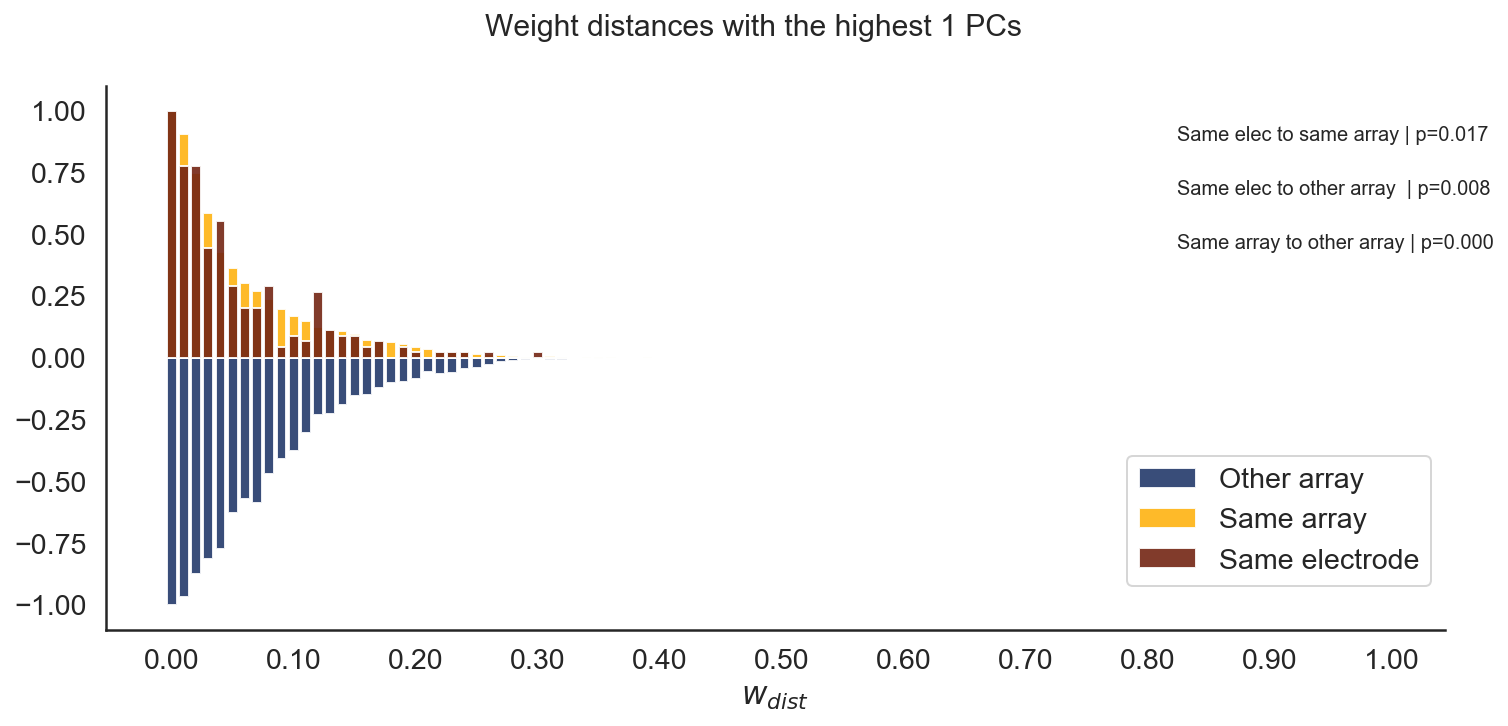

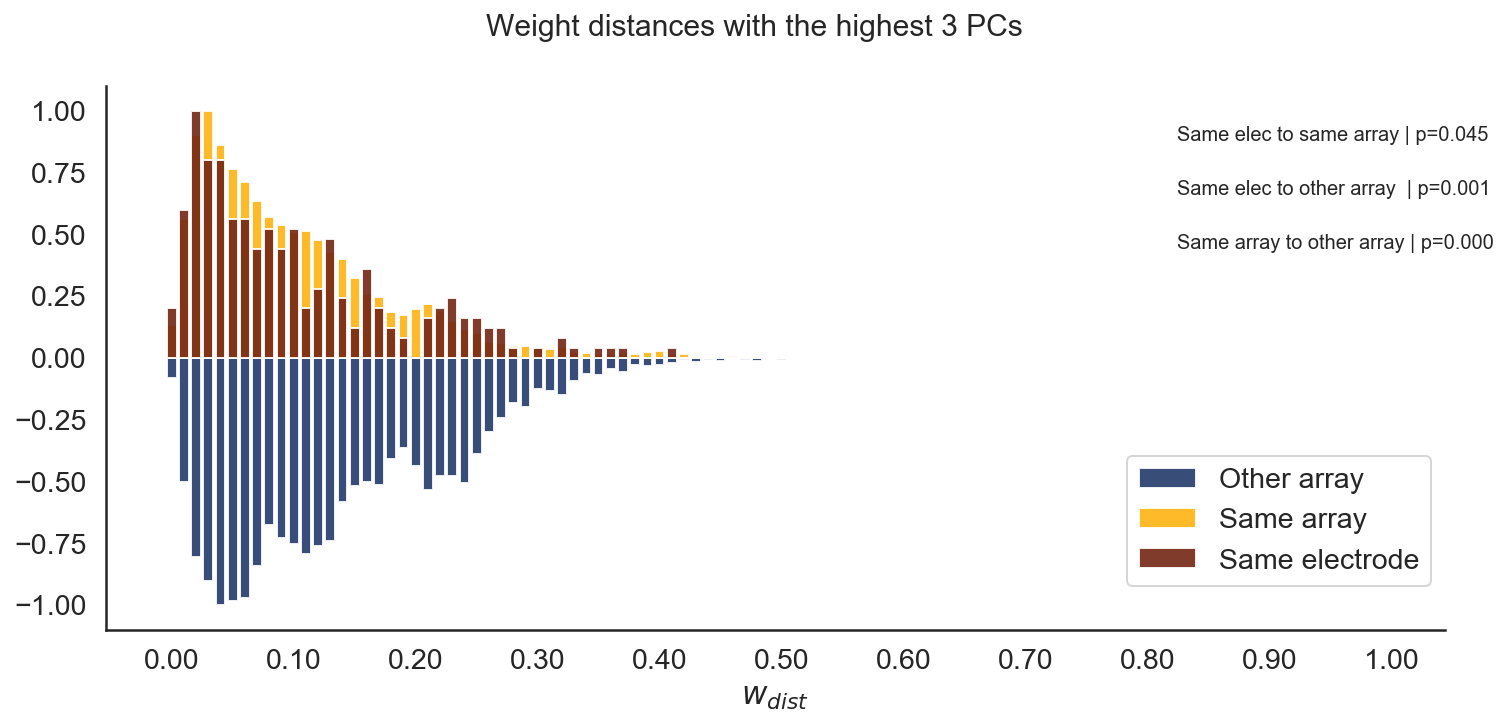

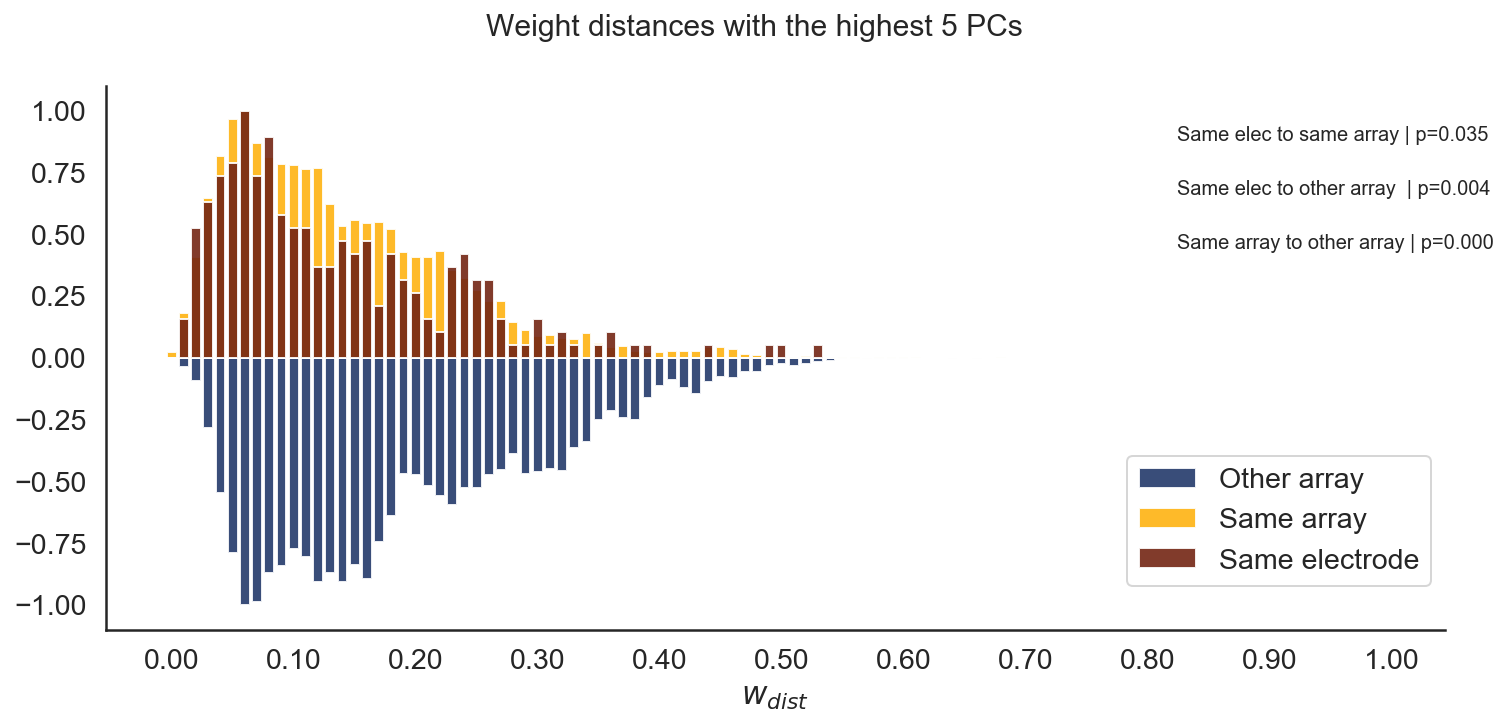

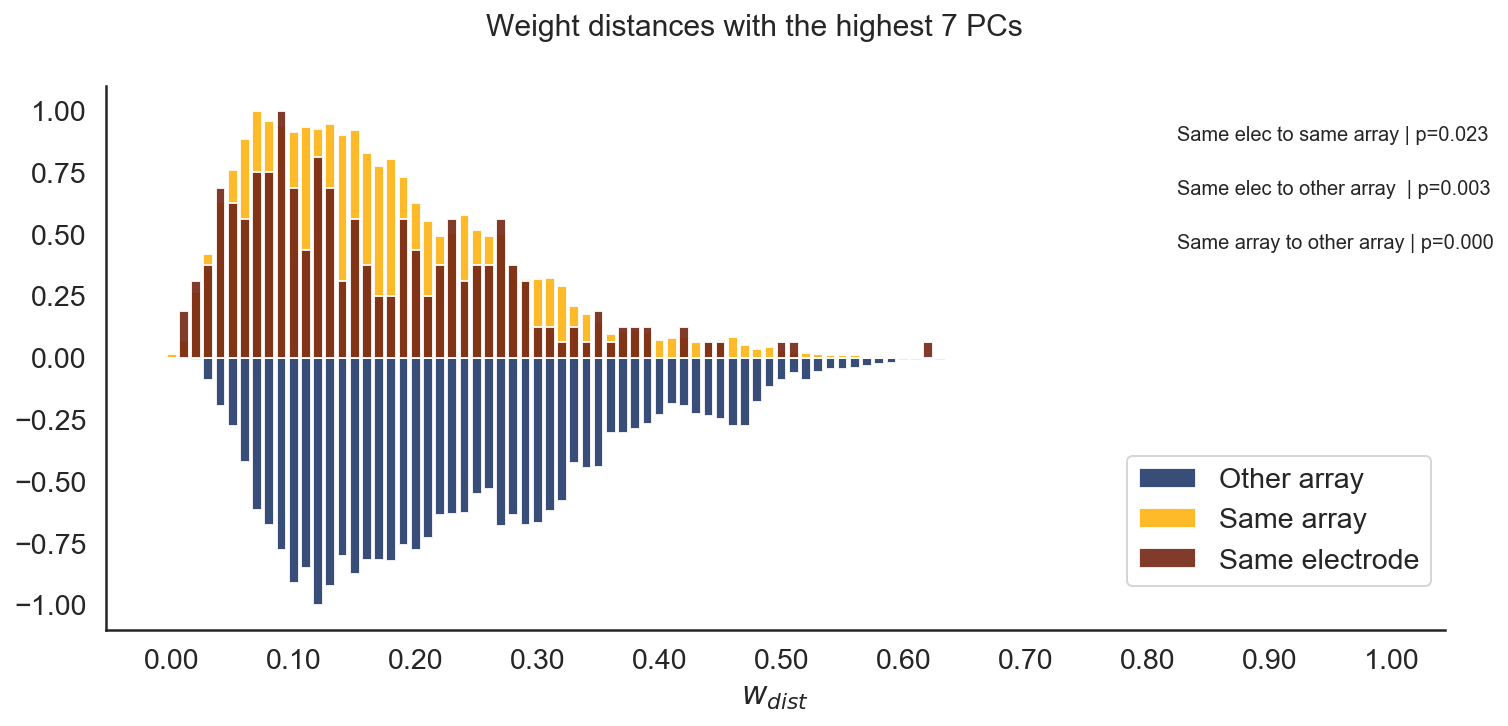

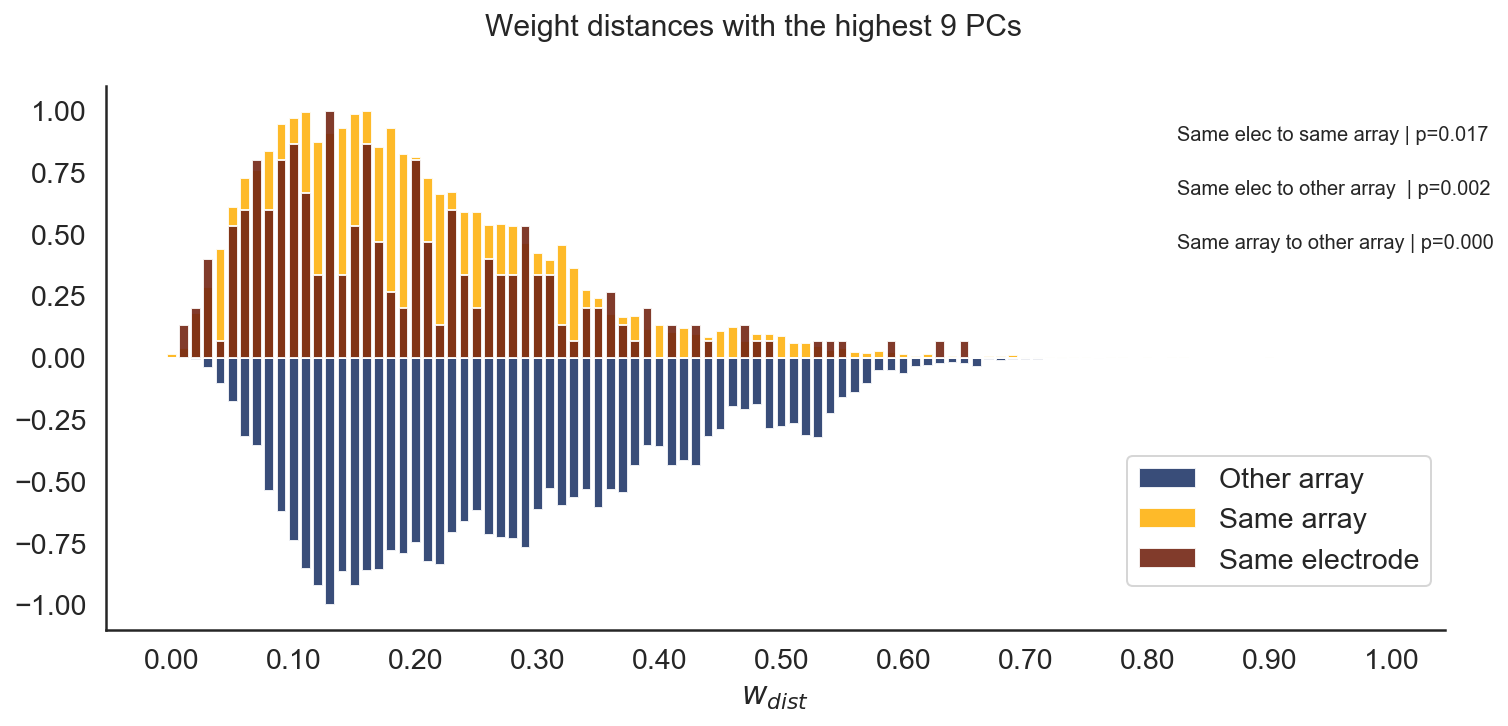

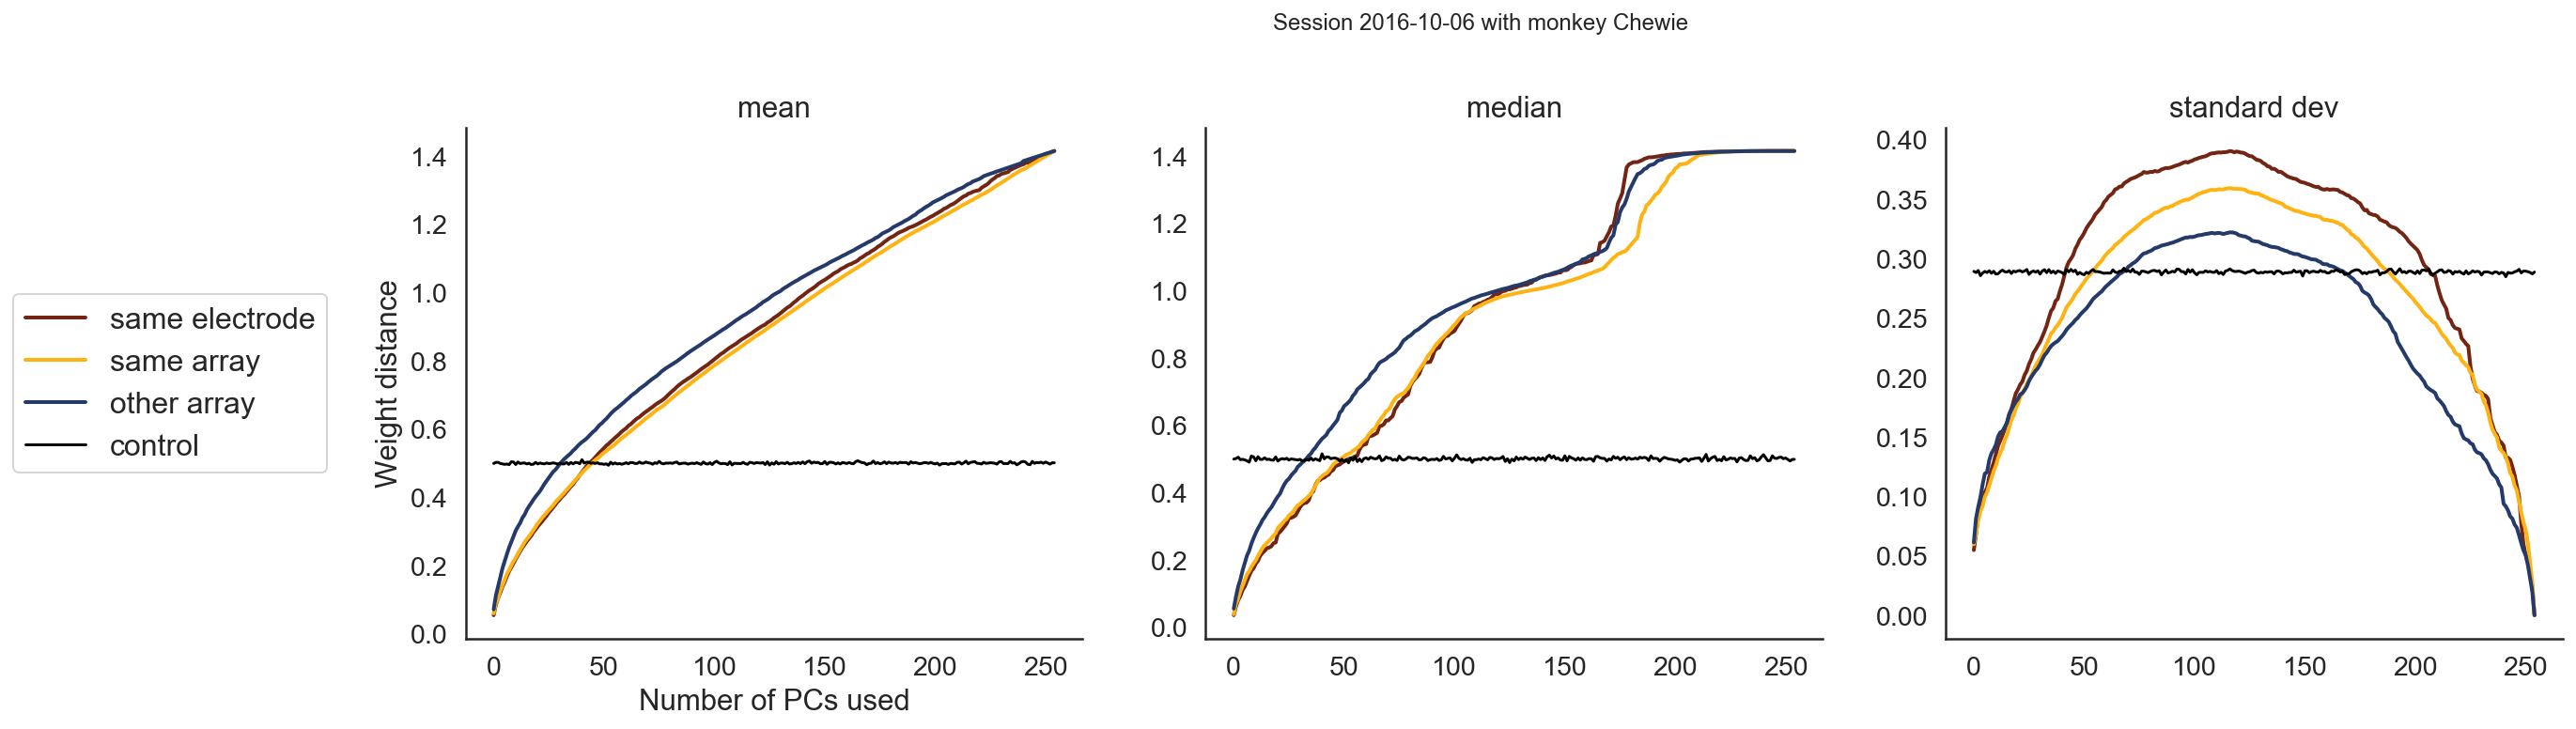

______________
Analysis Done
______________


In [7]:
session = 'Chewie_CO_VR_2016-10-06.mat' # Other file

run_analyses(session)

In [3]:
def run_analyses(session, r_f=10, dim_start=1, dim_stop=10):
    '''
    Perform several analyses 
    
    Parameters
    ----------
    session: the trialdata to work with 

    '''
    df = mat2dataframe('/Users/Daphne/Data/' + session, shift_idx_fields=True)
    # Extract date and monkey for plotting
    date = '-'.join(re.findall('[0-9]+', session))
    monkey = session[:6]
    # Read in cmp file and get electrode map
    m1_elecmap  = localize_elecs(read_cmp(file_path='/Users/Daphne/Data/Chewie Left M1 SN 6250-001474.cmp'), elecs=range(1,97))
    pmd_elecmap = localize_elecs(read_cmp(file_path='/Users/Daphne/Data/Chewie Left PMd SN 6251-001469.cmp'), elecs=range(1,97))

    
    print('___________')
    print(f'Analyzing session {date} with {monkey}')
    print('___________')

    '''
    (1) Preprocessing
    '''
    # Combine bins 
    td = combine_time_bins(df, n_bins=3)

    # Remove low firing neurons
    td = remove_low_firing_neurons(td, signal='M1_spikes',  threshold=0)
    td = remove_low_firing_neurons(td, signal='PMd_spikes', threshold=0)

    # Sqrt transform neurons
    td = transform_signal(td, signals='M1_spikes',  transformations='sqrt')
    td = transform_signal(td, signals='PMd_spikes', transformations='sqrt')

    # Merge signals
    td = merge_signals(td, ['M1_spikes', 'PMd_spikes'], 'both_spikes')

    # Calculate firing rates from spikes, works on '_spikes' fields and automatically divides by bin_size
    td = add_firing_rates(td, 'smooth', std=0.05)
    
    '''
    (2) Do PCA
    '''
    
    # We want to get a PC for all neurons
    pca_dims = td.both_rates[0].shape[1]

    # Perform dimensionality reduction on all trialdata
    # This function concatenates the data by trials over time and performs the dimensionality reduction on that 2d matrix
    td, model_m1pmd = tools.dim_reduce(td, PCA(pca_dims), 'both_rates', 'both_pca', return_model=True)
    
    # Transpose to get neurons x PCs
    m1pmd_pcs = model_m1pmd.components_.T
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
    fig.suptitle(f'Explained variance on firing rates on all {td.both_rates[0].shape[1]} recorded neurons')
    ax1.plot(model_m1pmd.explained_variance_ratio_.cumsum(), '.-')
    ax1.set_xlabel('PC')
    ax1.set_ylabel('explained variance')

    ax2.bar(range(len(model_m1pmd.explained_variance_ratio_)), model_m1pmd.explained_variance_ratio_, alpha=1, align='center')
    ax2.set_xlabel('PC')
    ax2.set_ylabel('explained variance')
    sns.despine()
    plt.show();
    
    '''
    (3) Compute distances for fixed number of PCs
    '''
    
    # Compute the spatial and weight distances with the first r PCs
    S_dist_m1, W_dist_m1, S_dist_pmd, W_dist_pmd, W_dist_oa = compare_r_pcs(pcs=m1pmd_pcs, r=r_f, m1_emap=m1_elecmap, m1_unitguide=td['M1_unit_guide'][0], 
                                                                            pmd_emap=pmd_elecmap, pmd_unitguide=td['PMd_unit_guide'][0])
    # Make groups within array based on spatial distance (same elec, same array)
    S_dist_both , W_dist_se, W_dist_sa = make_groups(S_dist_m1, W_dist_m1, S_dist_pmd, W_dist_pmd)
    
    # 3a) Plot kde densities
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

    fig.suptitle(r'$\bf{M1}$ and $\bf{PMd}$', y=1.02, fontsize=16)
    axs[0].set_title('Same electrode')
    sns.violinplot(W_dist_se, color=cs[0], ax=axs[0])
    axs[0].set_xlim([-0.1, 1])

    axs[1].set_title('Same array')
    sns.violinplot(W_dist_sa, color=cs[1], ax=axs[1])
    axs[1].set_xlim([-0.1, 1])

    axs[2].set_title('Other array')
    sns.violinplot(W_dist_oa, color=cs[2], ax=axs[2])
    axs[2].set_xlim([-0.1, 1])

    axs[0].annotate(f'mean  | median | std \n {np.mean(W_dist_se):0.3f} | {np.median(W_dist_se):0.3f}    | {np.std(W_dist_se):0.3f}', xy=(0.6, 0.75), xycoords=axs[0].transAxes, fontsize=14)
    axs[1].annotate(f'mean  | median | std \n {np.mean(W_dist_sa):0.3f} | {np.median(W_dist_sa):0.3f}    | {np.std(W_dist_sa):0.3f}', xy=(0.6, 0.75), xycoords=axs[1].transAxes, fontsize=14)
    axs[2].annotate(f'mean  | median | std \n {np.mean(W_dist_oa):0.3f} | {np.median(W_dist_oa):0.3f}    | {np.std(W_dist_oa):0.3f}', xy=(0.6, 0.75), xycoords=axs[2].transAxes, fontsize=14)

    sns.despine()
    plt.show()
    
    
    '''
    (4) Compute weight distances distributions for range of PCs 
    '''

    for r in np.arange(dim_start, dim_stop, 2):

        # Compute the spatial and weight distances with the first r PCs
        S_dist_m1, W_dist_m1, S_dist_pmd, W_dist_pmd, W_dist_oa = compare_r_pcs(pcs=m1pmd_pcs, r=r, m1_emap=m1_elecmap, m1_unitguide=td['M1_unit_guide'][0], 
                                                                                pmd_emap=pmd_elecmap, pmd_unitguide=td['PMd_unit_guide'][0])
        # Make groups within array based on spatial distance (same elec, same array)
        _ , W_dist_se, W_dist_sa = make_groups(S_dist_m1, W_dist_m1, S_dist_pmd, W_dist_pmd)

        # Make distribution
        standardized_hist(W_dist_se, W_dist_sa, W_dist_oa, r)
    
    
    '''
    (5) Make combi plot with control
    '''
    
    R = td.both_rates[0].shape[1] # For all columns

    # Want to track the mean, median and std as r changes
    stats_same_elec = np.zeros((3, R)) 
    stats_same_arr  = np.zeros((3, R)) 
    stats_other_arr = np.zeros((3, R)) 
    stats_rand_case = np.zeros((3, R))

    for i in range(R):

        r = i + 1

        # Compute the spatial and weight distances with the first r PCs
        S_dist_m1, W_dist_m1, S_dist_pmd, W_dist_pmd, W_dist_oa = compare_r_pcs(pcs=m1pmd_pcs, r=r, m1_emap=m1_elecmap, m1_unitguide=td['M1_unit_guide'][0], 
                                                                                pmd_emap=pmd_elecmap, pmd_unitguide=td['PMd_unit_guide'][0])
        # Make groups within array based on spatial distance (same elec, same array)
        _ , W_dist_se, W_dist_sa = make_groups(S_dist_m1, W_dist_m1, S_dist_pmd, W_dist_pmd)

        # Generate normal distributed matrix of values between 0 and 1 (control)
        W_dist_rand = np.abs(np.random.rand(W_dist_oa.shape[0]))

        # Compute statistics in each group and store
        stats_same_elec[0, i] = np.mean(W_dist_se) 
        stats_same_elec[1, i] = np.median(W_dist_se) 
        stats_same_elec[2, i] = np.std(W_dist_se) 

        stats_same_arr[0, i] = np.mean(W_dist_sa) 
        stats_same_arr[1, i] = np.median(W_dist_sa) 
        stats_same_arr[2, i] = np.std(W_dist_sa) 

        stats_other_arr[0, i] = np.mean(W_dist_oa) 
        stats_other_arr[1, i] = np.median(W_dist_oa) 
        stats_other_arr[2, i] = np.std(W_dist_oa) 

        stats_rand_case[0, i] = np.mean(W_dist_rand) 
        stats_rand_case[1, i] = np.median(W_dist_rand) 
        stats_rand_case[2, i] = np.std(W_dist_rand)
        
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), sharex=True)
    # Plot all the means
    fig.suptitle(f'Session {date} with monkey {monkey}', y=1.05)
    axs[0].set_title('mean')
    axs[0].plot(stats_same_elec[0, :], lw=2, label='same electrode')
    axs[0].plot(stats_same_arr[0, :],  lw=2, label='same array')
    axs[0].plot(stats_other_arr[0, :], lw=2, label='other array')
    axs[0].plot(stats_rand_case[0, :], 'k', lw=1.5, label='control')
    axs[0].set_xlabel('Number of PCs used')
    axs[0].set_ylabel('Weight distance')

    # Plot all the medians
    axs[1].set_title('median')
    axs[1].plot(stats_same_elec[1, :], lw=2)
    axs[1].plot(stats_same_arr[1, :],  lw=2)
    axs[1].plot(stats_other_arr[1, :], lw=2)
    axs[1].plot(stats_rand_case[1, :], 'k', lw=1.5)

    # Plot all the standard deviations
    axs[2].set_title('standard dev')
    axs[2].plot(stats_same_elec[2, :], lw=2)
    axs[2].plot(stats_same_arr[2, :],  lw=2)
    axs[2].plot(stats_other_arr[2, :], lw=2)
    axs[2].plot(stats_rand_case[2, :], 'k', lw=1.5)

    axs[0].legend(loc='center right', bbox_to_anchor=(-0.2, 0.5), fontsize=16)
    sns.despine()
    plt.show();
    
    print('______________')
    print('Analysis Done')
    print('______________')
    
